NB: questo codice contiene analisi di infograph da diversi punti di vista, UMLS, doc2vecc, lunghezza testo e fonte provenienza...

Inoltre trattiamo qua senza i documenti del layer 3 di AIFA circa 8000, quindi stiamo lavorando con circa 2000 documenti. Osservo che un codice analogo a questo ma che tratta anche gli embeddings di AIFA  è presente nella cartella InfoGraphMieModifiche, con lo stesso nome del codice.

# UMLS

In [1]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
import requests
import numpy as np

import pickle
from sklearn.cluster import KMeans
import numpy as np

Importo la lista contenente i broader concepts di ogni documento (utilizzando la api di umls):

In [2]:
with open('FilePickles\documents_broader.pkl', 'rb') as file:
    documents_broader = pickle.load(file)

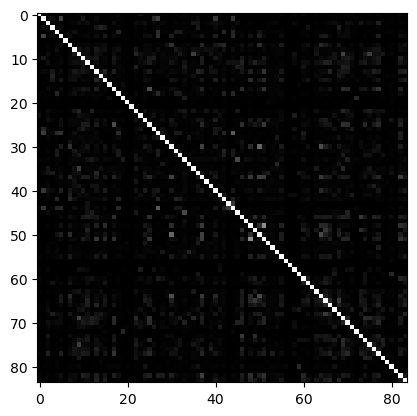

In [3]:
SIM = np.zeros((len(documents_broader),len(documents_broader)),dtype=float)
for curr in range(len(documents_broader)):
    # Itera su ogni documento in analisi
    for i in range(len(documents_broader)):
        # Calcola l'intersezione tra le entità cliniche più ampie dei documenti
        intersez = set(documents_broader[curr]).intersection(set(documents_broader[i]))
        union = set(documents_broader[curr]).union(set(documents_broader[i]))
        # Aggiorna la matrice SIM con la lunghezza dell'intersezione
        # Calcola il coefficiente di Jaccard e aggiorna la matrice SIM
        SIM[curr, i] = len(intersez) / len(union)
import matplotlib.pyplot as plt

plt.imshow(SIM, cmap='gray')
plt.show()

***
***
FACCIO CLUSTERING CON QUESTA MATRICE DI SIMILARITA (SIM)
***
***

HIERARCHICAL AGGLOMERATIVE:

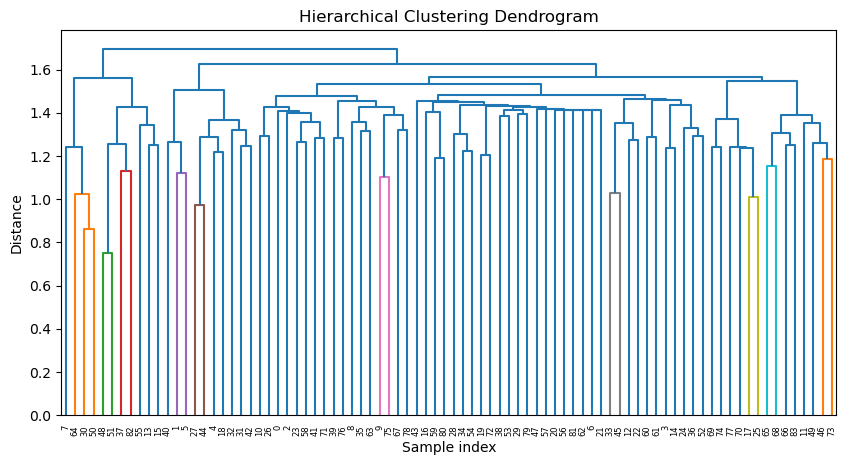

Numero di cluster: 3
Etichette dei cluster: [2 1 2 2 1 1 2 0 2 2 2 2 2 0 2 0 2 2 1 2 2 2 2 2 2 2 2 1 2 2 0 1 1 2 2 2 2
 0 2 2 1 2 1 2 1 2 2 2 0 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2]


In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(SIM, method='complete') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 1.6  # Altezza di taglio del dendrogramma
clustersHierarchicalUMLS = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicalUMLS))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicalUMLS)

KMEANS:
https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p
kmeans non va bene su matrice di similarità quindi adottiamo k-medoids per tutti i clusters di questo tipo!

In [5]:
import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(SIM)
clustersKMEDOIDSUMLS = kmedoids.labels_

***
***
FACCIO RANKING BASED METHODS CON LA MATRICE DI SIMILARITA'(SIM)
***
***

In [6]:
# Indici degli elementi di ciascuna riga ordinati in base al valore della similarità
sorted_indices = np.argsort(-SIM, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
SIMrank = np.zeros_like(SIM, dtype=int)
for i in range(len(SIM)):
    SIMrank[i] = sorted_indices[i]

print(SIMrank)
    

[[ 0 23 10 ... 56 43 49]
 [ 1  5 27 ... 50 30 83]
 [ 2 77 35 ... 62 47 57]
 ...
 [81 53 52 ... 27 34 41]
 [82 37 51 ... 81 58 59]
 [83 68 48 ... 58 72 62]]


In [7]:
import scipy
x=SIMrank[0]
y =SIMrank[23]
scipy.stats.kendalltau(x, y)

KendalltauResult(correlation=-0.06425702811244981, pvalue=0.38685684794551356)

# INFOGRAPH

***
***
EMBEDDINGS
***
***

In [8]:
#with open('EmbeddingLayer1and3_InfoGraphTRANSDUCTIVE.pklhidden_dim32num_gc_layers3lr0', 'rb') as file: #importo gli embedding dei grafi di layer 3
    #emb1and3 = pickle.load(file)
#emb1and3 = np.delete(emb1and3, 38, axis=0)  # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
#emb1and3 = np.delete(emb1and3, 84, axis=0) # e 9056 l'ultimo file ovvero IT102068.xml) (l'86esimo ma ho gia rimosso uno quindi scala)

#emb1 = emb1and3[0:86] # seleziono i primi 86 documenti, ovvero quelli relativi a layer 1
#siccome questi due file non contengono clinical entities!
#emb3 = emb1and3[86:]

#stringa_AIFA = ''

In [9]:
with open('FilePickles\EmbeddingLayer1and3_InfoGraphTRANSDUCTIVEhidden_dim32num_gc_layers3lr0.01_senza_AIFA.pkl', 'rb') as file: #importo gli embedding dei grafi di layer 3
    emb1and3 = pickle.load(file)
emb1and3 = np.delete(emb1and3, 38, axis=0)  # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
emb1and3 = np.delete(emb1and3, 84, axis=0) # e 9056 l'ultimo file ovvero IT102068.xml) (l'86esimo ma ho gia rimosso uno quindi scala)

emb1 = emb1and3[0:84] # seleziono i primi 86 documenti, ovvero quelli relativi a layer 1
#siccome questi due file non contengono clinical entities!
emb3 = emb1and3[84:]

stringa_AIFA = '_senza_AIFA'

In [10]:
len(emb1and3)

2213

PCA

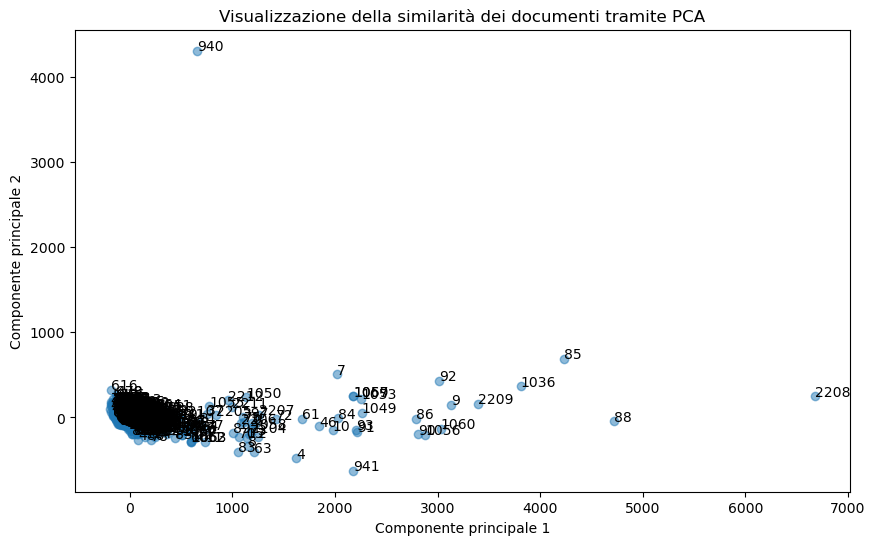

In [11]:
import numpy as np



document_vectors = emb1and3
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2. Applica PCA per ridurre le dimensioni
pca = PCA(n_components=2)  # Vogliamo ridurre a due dimensioni per la visualizzazione
document_embedding = pca.fit_transform(document_vectors)

# 3. Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(document_embedding[:, 0], document_embedding[:, 1], alpha=0.5)
plt.title('Visualizzazione della similarità dei documenti tramite PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')

# Aggiungi etichette per i punti (opzionale)
for i, txt in enumerate(range(len(document_vectors))):
    plt.annotate(txt, (document_embedding[i, 0], document_embedding[i, 1]))

plt.show()



In [12]:
emb1and3[7].mean()

118.266335

In [13]:
#emb1and3[7203].mean()

TSNE

In [14]:
from sklearn import datasets
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsneInfoGraph = tsne.fit_transform(emb1and3)  # embeddings è la tua matrice di embedding

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


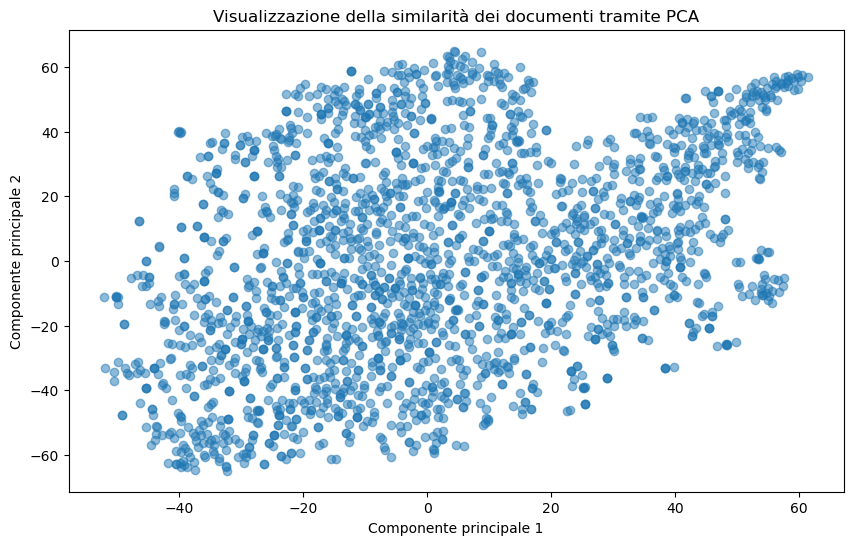

In [15]:
import numpy as np

document_vectors = emb1and3
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 3. Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_tsneInfoGraph[:, 0], embeddings_tsneInfoGraph[:, 1], alpha=0.5)
plt.title('Visualizzazione della similarità dei documenti tramite PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')


plt.show()


***
***
SIMILARITA (COSINE) E CLUSTERING
***
***

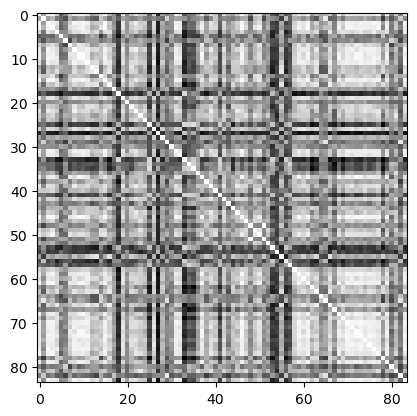

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrix = cosine_similarity(emb1) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='gray')
plt.show()

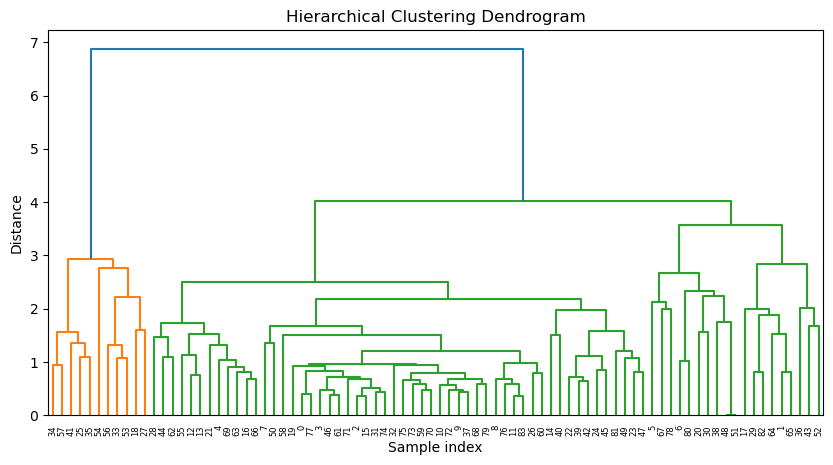

Numero di cluster: 63
Etichette dei cluster: [24 56 26 25 20 47 48 22 31 29 29 31 14 15 35 26 17 59  8 27 50 21 38 41
 39  2 32  9 13 54 51 26 30  5  0  3 62 29 53 37 36  4 37 60 11 40 25 42
 52 43 23 52 61  6 10 16  7  1 34 28 33 25 12 18 58 57 17 45 29 19 28 26
 29 28 26 28 31 24 46 29 49 44 55 31]


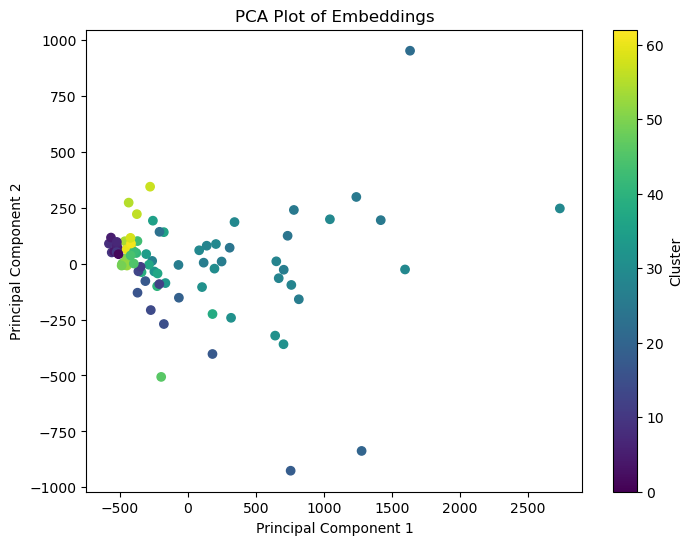

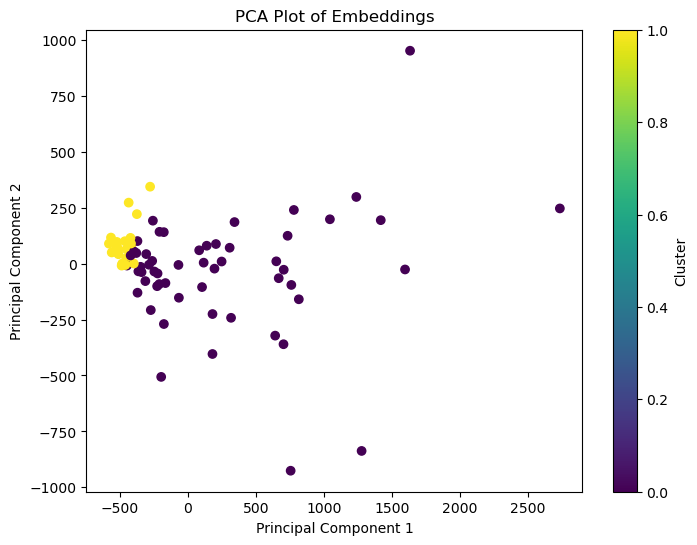

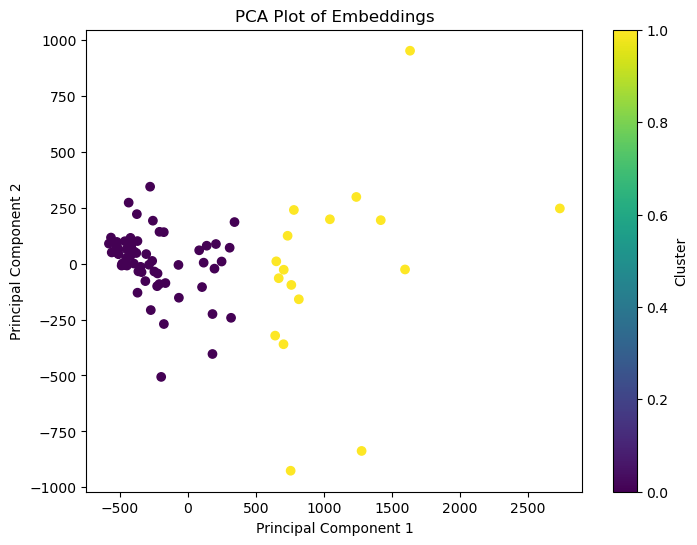

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(similarity_matrix, method='average') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 0.7  # Altezza di taglio del dendrogramma
clustersHierarchicalInfoGraph = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicalInfoGraph))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicalInfoGraph)

#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSInfoGraph = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

# infograph embedding:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb1)
clustersKMEANSInfoGraphEMB1 = kmeans.labels_


import numpy as np
from sklearn.decomposition import PCA

# Calcola PCA sui tuoi embedding
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pca = pca.fit_transform(emb1)  # embeddings è la tua matrice di embedding


#************************************************************************************************
#************************************************************************************************

#NB faccio pca su emb1 ma forse ha piu senso farlo su emb1and3 e poi valutare i risultati sul grafico solo per emb1!

#************************************************************************************************
#************************************************************************************************






# Visualizza solo i primi 84 embedding
embeddings_pca = embeddings_pca[:84]

# Plotta i risultati
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersHierarchicalInfoGraph[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEDOIDSInfoGraph[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Confrontiamo i due cluster precedenti con i cluster ottenuti direttamente dagli embedding (no matrice di similarità ma emb1and3)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEANSInfoGraphEMB1[:84], cmap='viridis')
plt.title('PCA Plot of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



In [18]:
explained_variance_ratio = pca.explained_variance_ratio_

print("Percentuale di varianza spiegata da ciascuna componente principale:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio*100:.2f}%")

Percentuale di varianza spiegata da ciascuna componente principale:
PC1: 73.62%
PC2: 9.42%


Osserviamo che la seconda componente principale sembra giocare un ruolo chiave nella distinzione dei clusters dati dalla matrice di similarità del coseno! Sembra esserci anche una correlazione fra PC1 e PC2 (strano!!)

Osserviamo anche che clustering con embedding vs clustering con matrice di similarità produce una bella differenza. (vedi l'ultimo grafico sopra vs i penultimi due)

***
***
Rankings UMLS vs ranking INFOGRAPH
***
***

In [19]:
# Indici degli elementi di ciascuna riga ordinati in base al valore della similarità
sorted_indices = np.argsort(-similarity_matrix, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
similarity_matrixrank = np.zeros_like(similarity_matrix, dtype=int)
for i in range(len(SIM)):
    similarity_matrixrank[i] = sorted_indices[i]

print(similarity_matrixrank)

[[ 0 77  3 ... 18 54 27]
 [ 1 65 29 ... 48 55 78]
 [ 2 15 76 ... 54 18 27]
 ...
 [81 23 36 ... 18 27 54]
 [82 29 65 ... 43 38 55]
 [83 11 73 ... 33 18 27]]


In [20]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(SIMrank[i], similarity_matrixrank[i])
    media+=kendalltau.correlation
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(SIMrank[1], similarity_matrixrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(SIMrank[i-1], similarity_matrixrank[i])
    #print(kendalltau.correlation)
    media+=kendalltau.correlation
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

0.017184383793678114 Correlazione Media UMLS vs Infograph
0.006631970057099144 Correlazione Media UMLS vs Infograph in maniera casuale


Notiamo che la correlazione di UMLS e infoGraph è comparabile alla variabile di controllo dove facciamo confronto a caso. (correlazione in media circa 0, e va da -1 a 1)

***
***
Valutazione documenti (vediamo leggendo i documenti se traspaiono delle somiglianze)
***
***

Creo lista_testi per avere a portata di mano il contenuto dei testi

In [21]:
import os
import json

# Definisci la cartella contenente i file
cartella = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_collection\Italian\layer1"

# Lista dei testi estratti
lista_testi1 = []
lista_source1 = []

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                # Estrai il testo dal campo "text" se presente
                if "text" in data:
                    testo = data["text"]
                    lista_testi1.append(testo)
                if "source" in data:
                    source = data["source"]
                    lista_source1.append(source)
            except Exception as e:
                pass

_ = lista_testi1.pop(38) # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
_ = lista_testi1.pop(84) #per rimuovere l'86esimo documento di layer 1 devo rimuovere l'85esimo per il pop di prima (quindi84)

_ = lista_source1.pop(38) # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
_ = lista_source1.pop(84) #per rimuovere l'86esimo documento di layer 1 devo rimuovere l'85esimo per il pop di prima (quindi84)

In [22]:
len(lista_source1)

84

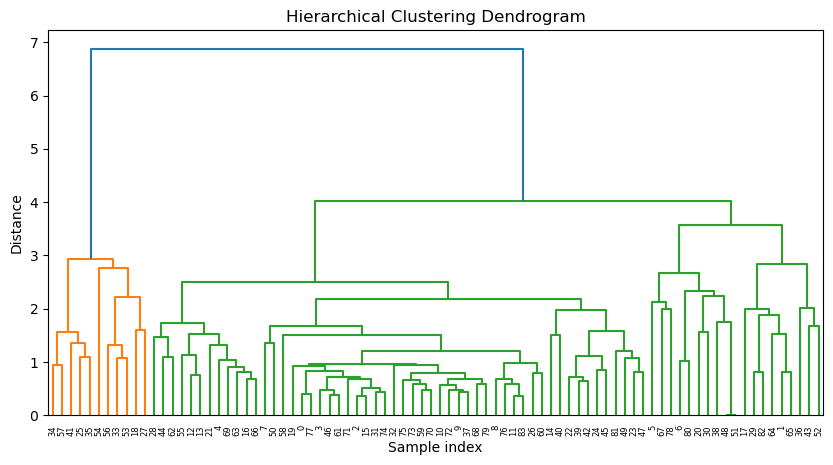

In [23]:
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [24]:
#Vedo se i clusters ottenuti da infoGraph hanno un significato:

# 23 e 50 formano il cluster uno a sinistra, vediamoli

print(lista_testi1[23],"\n\n",lista_testi1[50])
print(similarity_matrix[23][50])

Caucasico di 68 anni viene sottoposto a coronarografia circa un’ora dopo la comparsa di sintomi di IMA. Viene praticata PTCA primaria. Dopo 6 giorni dalla procedura, comparsa di dolore alle dita dei piedi con cianosi e marezzatura. Progressivo peggioramento del quadro periferico fino alla comparsa di aree di necrosi parcellari alle dita dei piedi. Incremento della creatinina (Cr.:3.2 mg%). Come da consulenza chirurgica, si procede ad amputazione di quattro dita del piede sx e due del piede dx. Al riscontro istologico quadro di embolizzazione da cristalli di colesterolo. Nei due mesi successivi progressivo recupero della funzione renale. 

 Il signor Ugo di anni 63 sposato con due figli, viene ricoverato nell'UO di Medicina per accertamenti. Al ricovero il signor Ugo presenta forti dolori addominali e vomito. Gli viene posizionato un sondino naso gastrico. Dopo vari accertamenti viene diagnosticato un K gastrico con metastasi del fegato e del pancreas. Il signor Ugo viene sottoposto ad 

osservo che questi due testi potrebbero andar messi nella testi siccome sono di layer 1 (quindi hanno le clinical entities e sono corti)!

In [25]:
#secondo cluster formato da 8 34 28 39

print(lista_testi1[8],"\n\n",lista_testi1[34],"\n\n",lista_testi1[28],"\n\n",lista_testi1[39])

print(similarity_matrix[8][34])
print(similarity_matrix[8][28])
print(similarity_matrix[8][39])
print(similarity_matrix[28][34])
print(similarity_matrix[39][34])
print(similarity_matrix[28][39])


Una donna di 48 anni viene ricoverata in ambiente ospedaliero nell’agosto del 2011 per la presenza, da circa un mese, di astenia marcata, gonfiore addominale e incremento ponderale. L’anamnesi patologica remota evidenzia un’ipertensione arteriosa scarsamente controllata dalla terapia farmacologica e una storia di ulcera gastrica, in terapia con inibitori di pompa protonica con risoluzione del quadro. Durante il ricovero vengono effettuati esami ematochimici con riscontro di: marcata anemia (Hb = 9,8 g/dl, vn = 12,0-16,0 g/dl); riduzione dell’ematocrito (ematocrito = 31,9%, vn = 37,0-47,0); leucocitosi neutrofila con linfocitopenia (neutrofili = 10,66 × 10³/μl, vn = 1,50-8,00 × 10³/μl; linfociti = 0,52 × 10³/μl, vn = 0,90-4,00 × 10³/μl); lieve rialzo delle transaminasi (GOT = 56 U/l, vn < 32 U/l; GPT = 89 U/l, vn < 31 U/l). All’esame obiettivo non sono presenti alterazioni di rilievo. Per ricercare la causa dell’anemia vengono eseguite una esofagogastroduodenoscopia, che rileva una gast

osservo che questi documenti hanno lunghezza diversa quindi sembra si possa escludere che l'embedding di infograph sia influenzato tanto dalla lunghezza del testo

In [26]:
#osservo che nella seconda metà ci sono 58 62 1 54 che sono molto simili dal dendogram, andiamo a vedere!

print(lista_testi1[58],"\n\n,oooooooooooooooooooooooooooooooooooo",lista_testi1[62],"\n\n,ooooooooooooooo",
      lista_testi1[1],"\n\noooooooooooooooooooooooooooooooooooooooooooooo",lista_testi1[54])

print(similarity_matrix[58][62])
print(similarity_matrix[58][1])
print(similarity_matrix[58][54])
print(similarity_matrix[1][62])
print(similarity_matrix[54][62])
print(similarity_matrix[54][1])

Nel luglio del 2002 abbiamo osservato una donna di 60 anni con febbre continua da 6 giorni e 5 escare localizzate a livello degli arti superiori e inferiori accompagnate da linfoadenopatia regionale. Tuttavia le condizioni generali erano buone, sia al momento della prima visita che nei giorni precedenti, e non si è manifestato esantema. La paziente aveva soggiornato in sud Africa per 20 giorni e i primi sintomi sono comparsi 6 giorni dopo il rientro in Patria. I principali esami emato chimici hanno mostrato una modesta ipertransaminasemia e un moderato incremento della VES. La diagnosi sierologica è stata effettuata mediante un test di immuno fluorescenza indiretta per la ricerca delle IgG ed IgM anti Rickettsia (Focus USA, Alifax). Il test utilizza vetrini contenenti antigeni di R. typhy e di R. rickettsii che consentono di discriminare, rispettivamente, il gruppo “Typhus Fever” da quello “Spotted Fever”, quest’ultimo comprendente anche R africae, R. akari, R. conorii, R.
australis, R

In [27]:
SIMrank[0]

array([ 0, 23, 10, 58, 82, 60,  9, 66, 44, 18, 71, 70, 55, 33, 26, 83, 77,
        2, 67, 31, 41, 75,  3, 63, 28, 45, 69, 42, 22, 11, 38, 12, 36, 53,
       61, 79,  5, 52, 13, 29,  4, 35, 54, 14, 39, 32, 65, 68, 24, 76,  8,
       64, 78, 80, 74,  1, 62, 81, 72, 73, 16, 57, 17, 19, 20, 21, 25, 27,
       30, 34, 37, 59, 40,  7, 46, 47, 48, 15, 50, 51,  6, 56, 43, 49])

In [28]:
similarity_matrixrank[0]

array([ 0, 77,  3, 15, 46, 61,  2, 10, 31, 68,  9, 71, 76, 79, 70,  8, 73,
       74, 37, 83, 59, 72, 75, 22, 50, 32, 19, 39, 11, 14, 60, 42, 49, 47,
        4, 26,  7, 58, 40, 45, 23, 81, 66, 24, 69, 21, 63, 36, 16, 13, 65,
       52,  1, 43, 38, 64, 12, 44, 55, 28, 62, 17, 30, 20, 51, 48,  6, 29,
       80, 78, 35, 82, 67, 34, 57, 41, 25,  5, 56, 53, 33, 18, 54, 27])

I risultati alla luce di tutto quanto visto sopra sembrano scoraggianti... sento vittorio.

# Doc2vec

Provo a vedere se doc2vec produce embedding migliori oppure no..., vedi file Doc2Vec_E3C (ho fatto copia incolla da li...), metto qua il codice per poter confrontare i risultati con UMLS e infograph

In [29]:
import pickle
import numpy as np

with open('FilePickles\corpusParoleInutiliStemming.pkl', 'rb') as file:
    # Carica i dati dal file
    corpus_filtrato = pickle.load(file)
#len(corpus_filtrato[0])

with open('FilePickles\corpusParoleInutiliStemming_layer1.pkl', 'rb') as file:
    # Carica i dati dal file
    corpus_filtrato1 = pickle.load(file)
#len(corpus_filtrato[0])

Importo il modello doc2vec trainato su layer 3


In [30]:
with open('FilePickles\modeldoc2vec_senza_AIFA.pkl', 'rb') as file:
    model = pickle.load(file)

In [31]:
embedding_docs1 = []
for doc in corpus_filtrato1:
    vector = model.infer_vector(doc)
    embedding_docs1.append(vector)
embedding_docs1 = np.delete(embedding_docs1, 38, axis=0)  # devo rimuovere il documento sofa 4178(IT100830.xml) (il 39esimo della cartella)
embedding_docs1 = np.delete(embedding_docs1, 84, axis=0) #(l'86esimo ma ho gia rimosso uno quindi scala)


Importo gli embeddings del doc3

In [32]:
with open('FilePickles\embedding_docs3doc2vec_senza_AIFA.pkl', 'rb') as file:
    embedding_docs3 = pickle.load(file)

In [33]:
len(embedding_docs1)

84

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


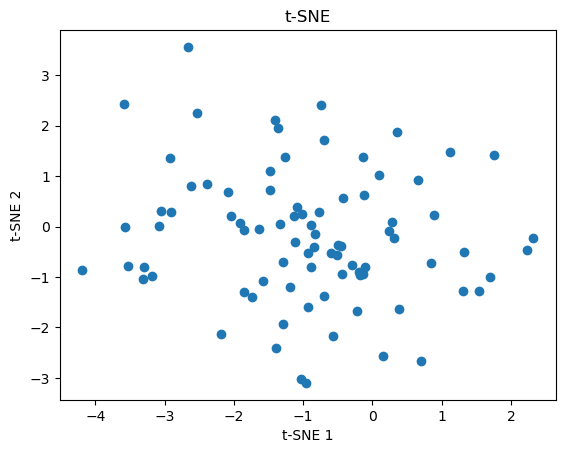

Varianza delle prime 2 componenti principali: [0.09521666 0.08481218]


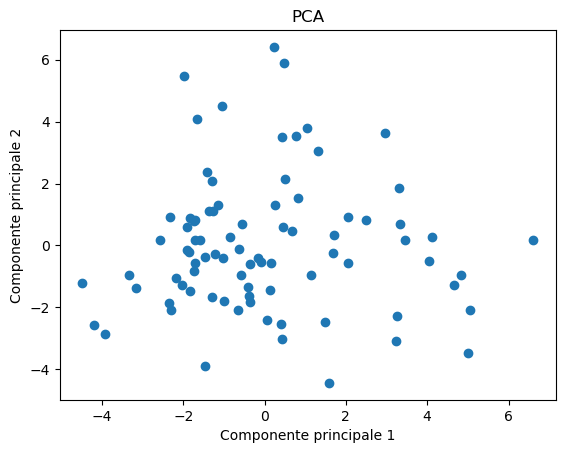

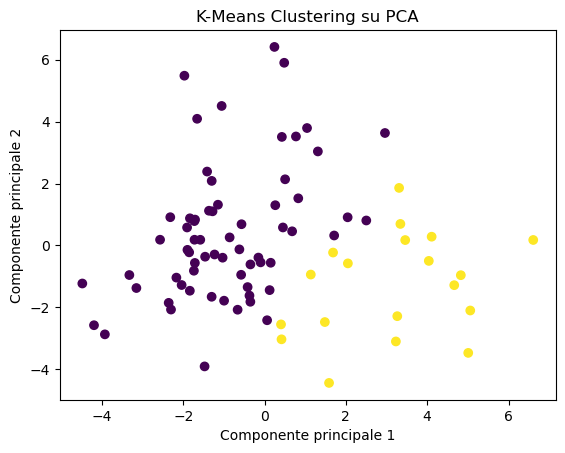

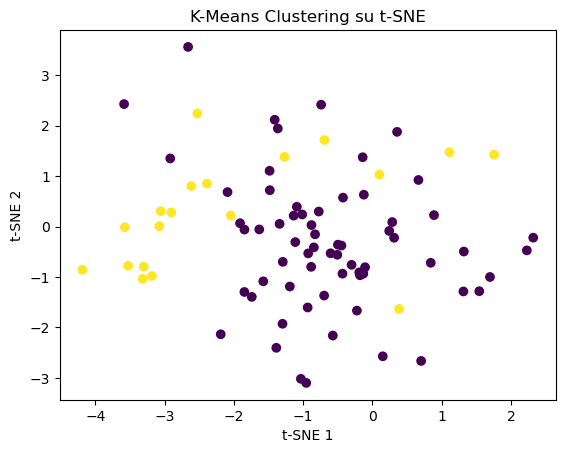

In [34]:
from sklearn.manifold import TSNE

# Esegui t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedding_docs1_tsne = tsne.fit_transform(embedding_docs1)

# Visualizzare i risultati su un piano bidimensionale
plt.scatter(embedding_docs1_tsne[:, 0], embedding_docs1_tsne[:, 1])
plt.title('t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Esegui PCA
pca = PCA(n_components=2)
embedding_docs1_pca = pca.fit_transform(embedding_docs1)

# Stampare la varianza delle prime 2 componenti principali
print("Varianza delle prime 2 componenti principali:", pca.explained_variance_ratio_)

# Visualizzare i risultati su un piano bidimensionale
plt.scatter(embedding_docs1_pca[:, 0], embedding_docs1_pca[:, 1])
plt.title('PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

from sklearn.cluster import KMeans

# Esegui K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(embedding_docs1)

# Visualizza i risultati su PCA
plt.scatter(embedding_docs1_pca[:, 0], embedding_docs1_pca[:, 1], c=kmeans.labels_)
plt.title('K-Means Clustering su PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

# Visualizza i risultati su t-SNE
plt.scatter(embedding_docs1_tsne[:, 0], embedding_docs1_tsne[:, 1], c=kmeans.labels_)
plt.title('K-Means Clustering su t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

kmeanemblabels = kmeans.labels_

Osservo che pca non va bene per rappresentare i dati in 2d perchè le prime due pc spiegano meno del 20% della variabilità

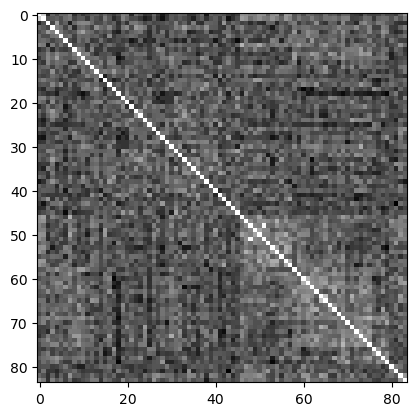

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrixdoc2vec = cosine_similarity(embedding_docs1) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrixdoc2vec, cmap='gray')
plt.show()

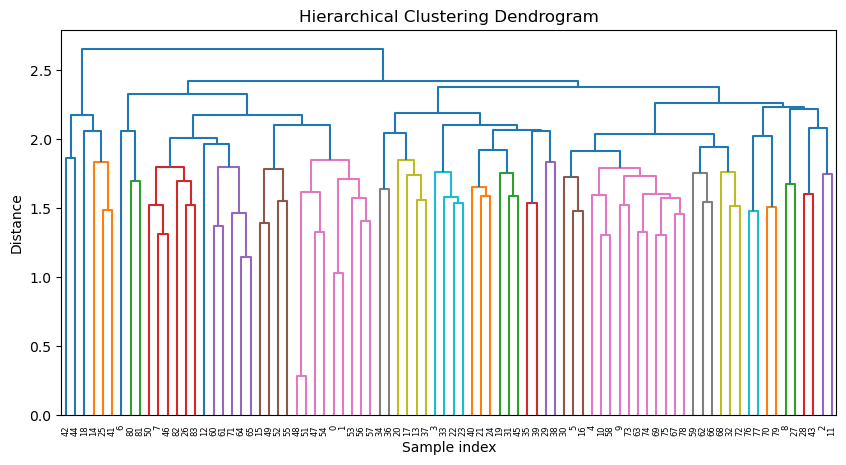

Numero di cluster: 39
Etichette dei cluster: [15 15 38 20 28 27  6  7 36 29 28 38 11 17  3 12 27 17  4 23 18 21 19 19
 21  2  8 36 37 25 27 22 32 19 16 24 16 17 26 24 21  2  0 37  1 22  7 14
 14 12  7 14 13 15 14 13 15 15 28 31  9  9 30 29 10 10 30 29 33 29 35 10
 32 29 29 29 34 34 29 35  5  5  8  8]


C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


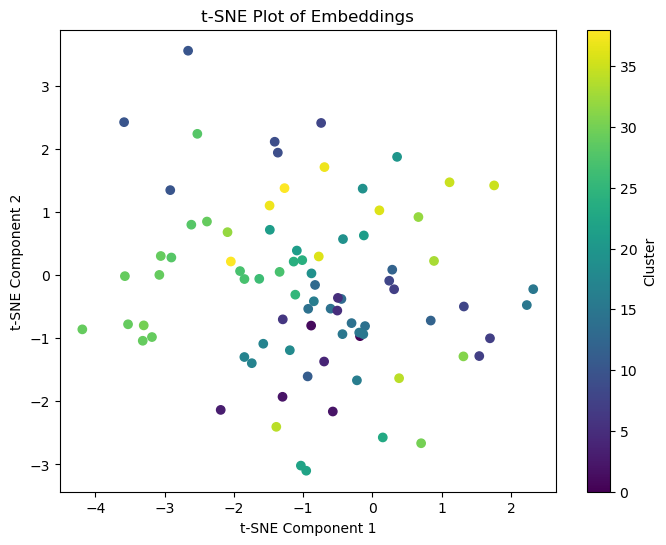

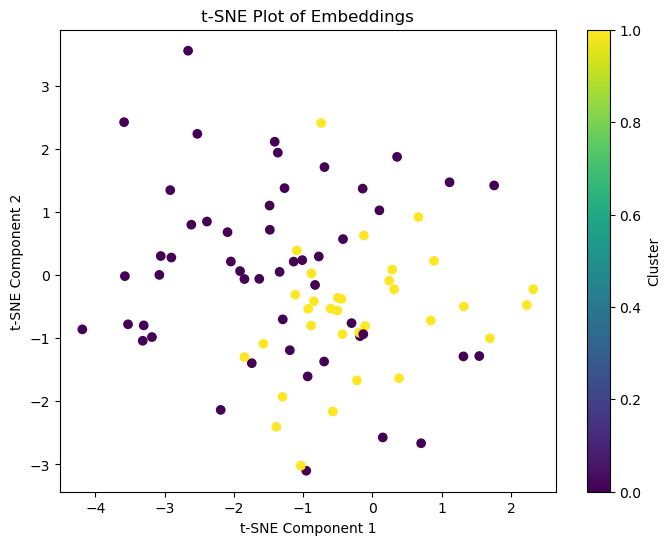

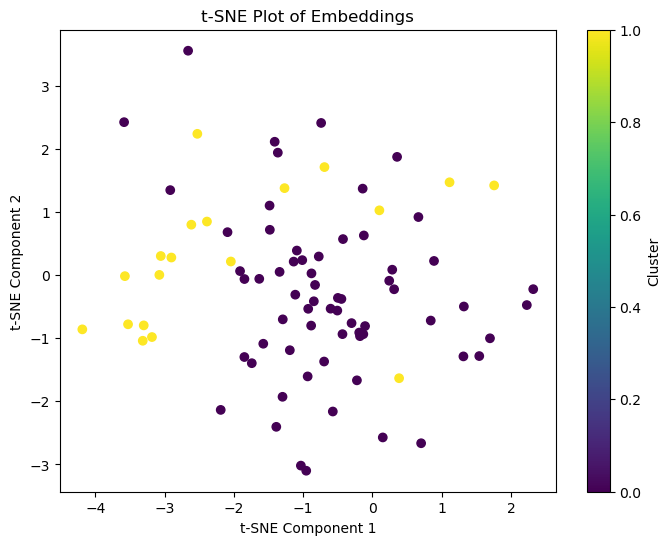

In [36]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calcola i collegamenti gerarchici basati sulla matrice di similarità
Z = linkage(similarity_matrixdoc2vec, method='average') # complete linkage mi sembra il migliore

# Plotta il dendrogramma per visualizzare la gerarchia dei cluster
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 1.75  # Altezza di taglio del dendrogramma
clustersHierarchicaldoc2vec = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicaldoc2vec))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicaldoc2vec)


#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrixdoc2vec)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]


from sklearn.manifold import TSNE

# Calcola t-SNE sui tuoi embedding
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs1)  # embeddings è la tua matrice di embedding

# Plotta i risultati
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicaldoc2vec[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vec[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Confrontiamo i due cluster precedenti con i cluster ottenuti direttamente dagli embedding (no matrice di similarità ma emb1and3)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=kmeanemblabels[:84], cmap='viridis')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


osservo che il dendogram non è un granche, kmeans embedding e k medoids sulla base della matrice di similarità producono risultati diversi

***
***
Rankings UMLS vs ranking INFOGRAPH vs doc2vec
***
***

In [37]:
sorted_indices = np.argsort(-similarity_matrixdoc2vec, axis=1)  # Ordina in ordine decrescente

# Costruisci la matrice SIMrank
similarity_matrixdoc2vecrank = np.zeros_like(similarity_matrixdoc2vec, dtype=int)
for i in range(len(similarity_matrixdoc2vec)):
    similarity_matrixdoc2vecrank[i] = sorted_indices[i]

print(similarity_matrixdoc2vecrank)

[[ 0  1 56 ...  2 28 38]
 [ 1  0 46 ... 24 43 28]
 [ 2  4 42 ... 51  0  7]
 ...
 [81 52 34 ... 24 33 43]
 [82 64 83 ...  2 38 44]
 [83 61 82 ... 14  2 38]]


doc2vec rankings vs umls

In [38]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(SIMrank[i], similarity_matrixdoc2vecrank[i])
    media+=np.abs(kendalltau.correlation)
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(SIMrank[1], similarity_matrixdoc2vecrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(SIMrank[i-1], similarity_matrixdoc2vecrank[i])
    #print(kendalltau.correlation)
    media+=np.abs(kendalltau.correlation)
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

0.0586290741196077 Correlazione Media UMLS vs Infograph
0.05949648935879576 Correlazione Media UMLS vs Infograph in maniera casuale


doc2vec rankings vs infograph

In [39]:
import scipy
media = 0
for i in range(len(SIMrank)):
    kendalltau = scipy.stats.kendalltau(similarity_matrixrank[i], similarity_matrixdoc2vecrank[i])
    media+=np.abs(kendalltau.correlation)
    #print(kendalltau)
media = media/len(SIMrank)
print(media,'Correlazione Media UMLS vs Infograph')

import scipy
media = 0
for i in range(len(SIMrank)):
    if i == 0:
        kendalltau = scipy.stats.kendalltau(similarity_matrixrank[1], similarity_matrixdoc2vecrank[i])
    else:
        kendalltau = scipy.stats.kendalltau(similarity_matrixrank[i-1], similarity_matrixdoc2vecrank[i])
    #print(kendalltau.correlation)
    media+=np.abs(kendalltau.correlation)
media = media/len(SIMrank)

print(media,'Correlazione Media UMLS vs Infograph in maniera casuale')

0.06403846679233943 Correlazione Media UMLS vs Infograph
0.05706499467256783 Correlazione Media UMLS vs Infograph in maniera casuale


***
***
Confronto k-medoids clustering (visualizzato su tsne per tutti i possibili metodi)
***
***

Utilizzo sempre il tsne di doc2vec in ogni grafico per avere che tutti i punti siano nelle stesse posizioni!

***

https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p
link utile per usare kmeans quando si ha una matrice di similarità

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


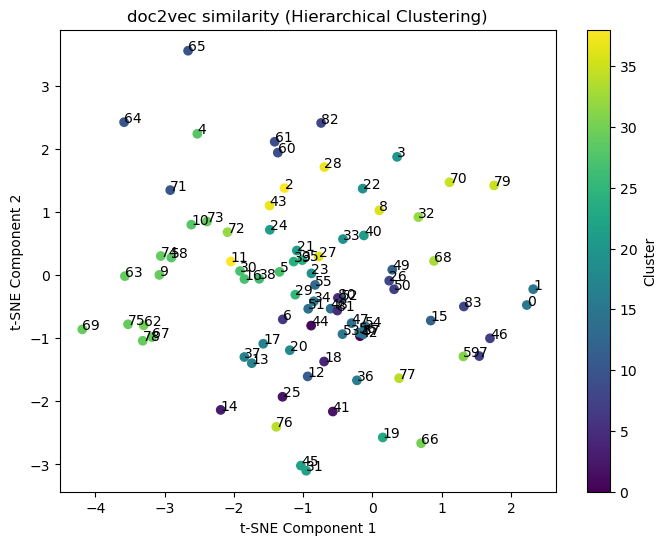

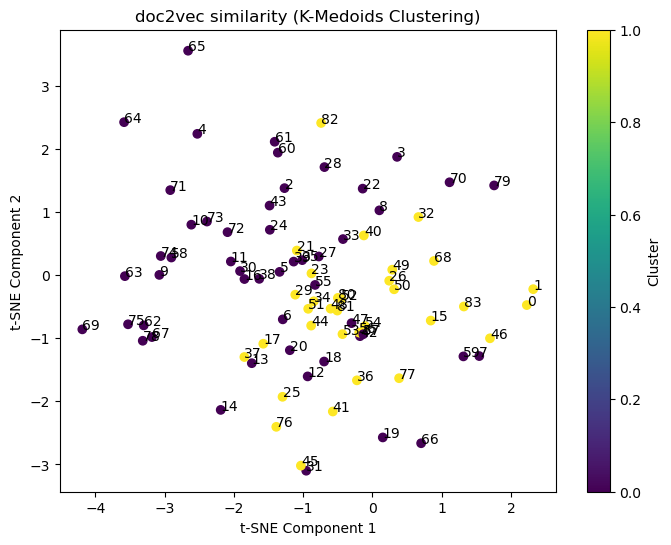

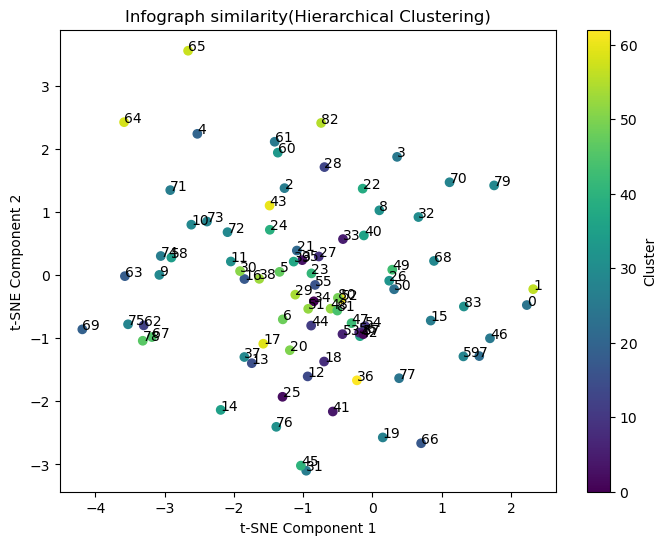

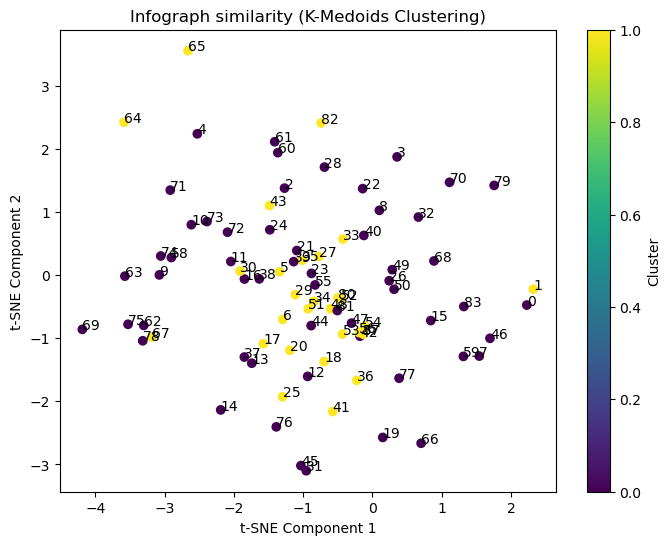

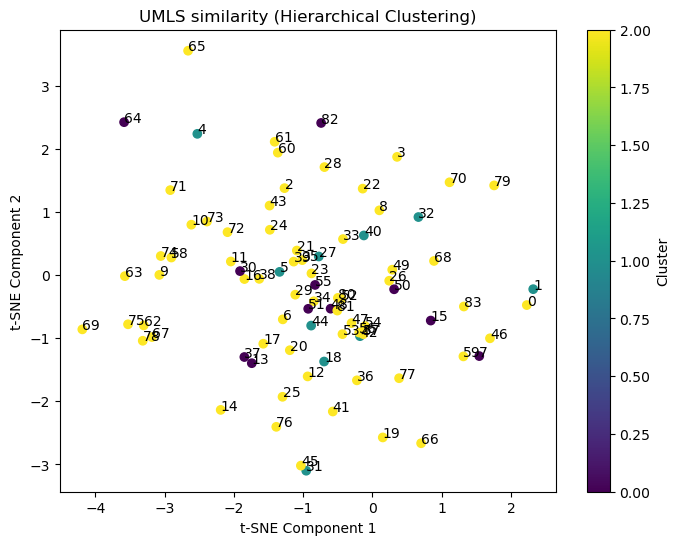

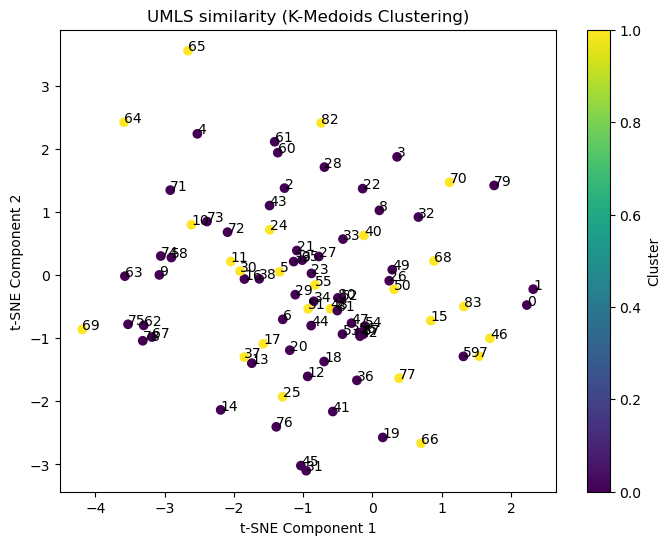

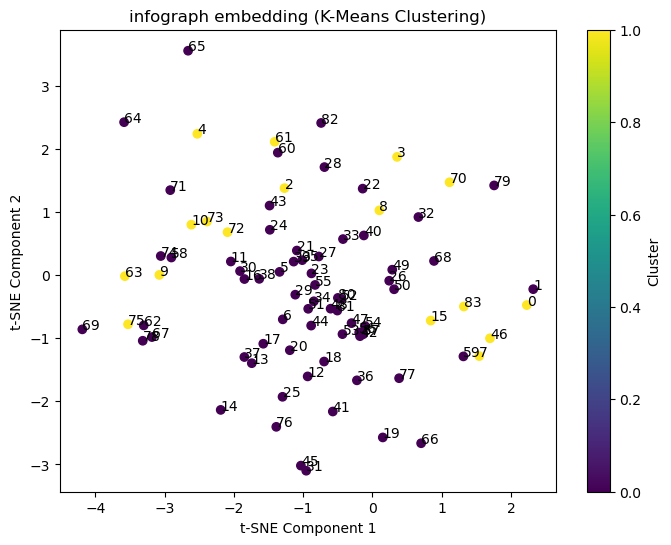

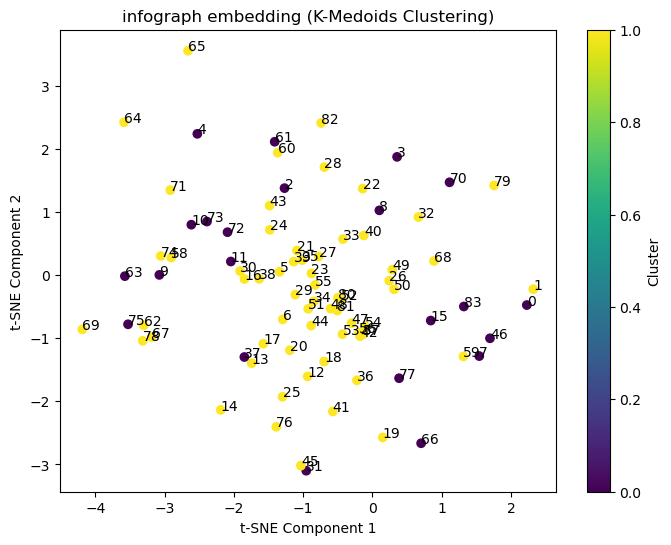

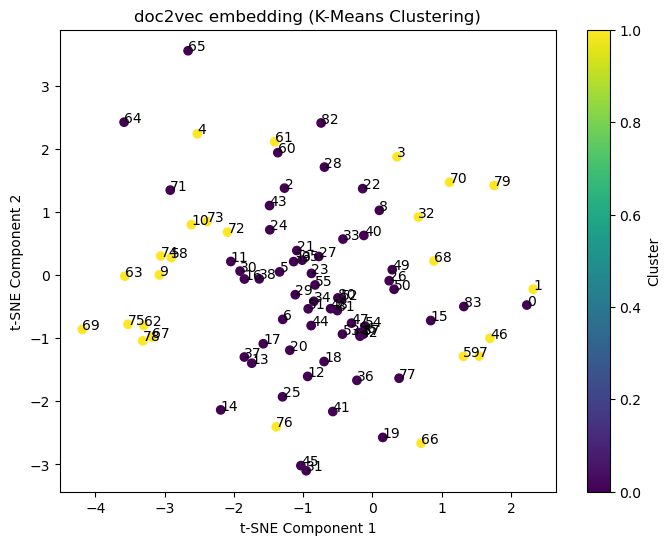

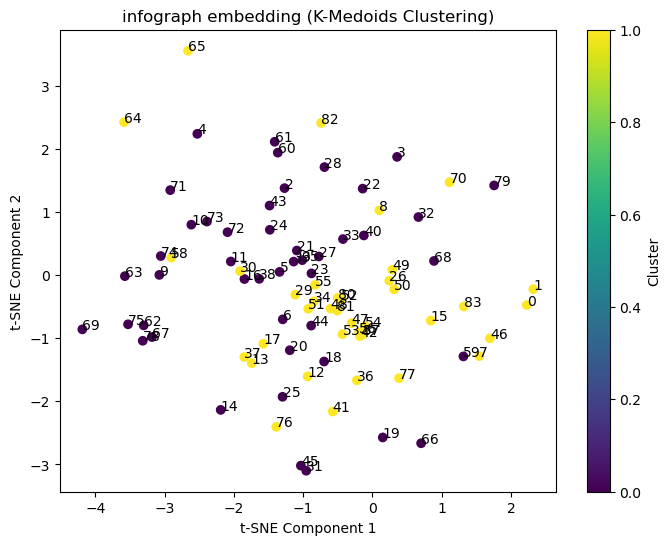

In [40]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs1)  # embeddings è la tua matrice di embedding



# doc2vec similarity:



# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicaldoc2vec[:84], cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vec[:84], cmap='viridis')
plt.title('doc2vec similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



# Infograph similarity:



# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicalInfoGraph[:84], cmap='viridis')
plt.title('Infograph similarity(Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraph[:84], cmap='viridis')
plt.title('Infograph similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# UMLS similarity:





# Plotta i risultati per Hierarchical Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersHierarchicalUMLS[:84], cmap='viridis')
plt.title('UMLS similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()
# Plotta i risultati per K-Means Clustering
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSUMLS[:84], cmap='viridis')
plt.title('UMLS similarity (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# clustering kmeans, k = 3 degli embedding di doc2vec e infograph dagli embedding direttamente (no matrice di similarità)




# infograph embedding:

#kmeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb1)
clustersKMEANSInfoGraphEMB = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSInfoGraphEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()


#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(emb1)
clustersKMEDOIDSInfoGraphEMB = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraphEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()




# doc2vec embedding:

#kmeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embedding_docs1)
clustersKMEANSdoc2vecEMB = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSdoc2vecEMB[:84], cmap='viridis')
plt.title('doc2vec embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()

#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(embedding_docs1)
clustersKMEDOIDSdoc2vecEMB = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vecEMB[:84], cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



stessa cosa di prima ma ora metto i plot in una tabella:

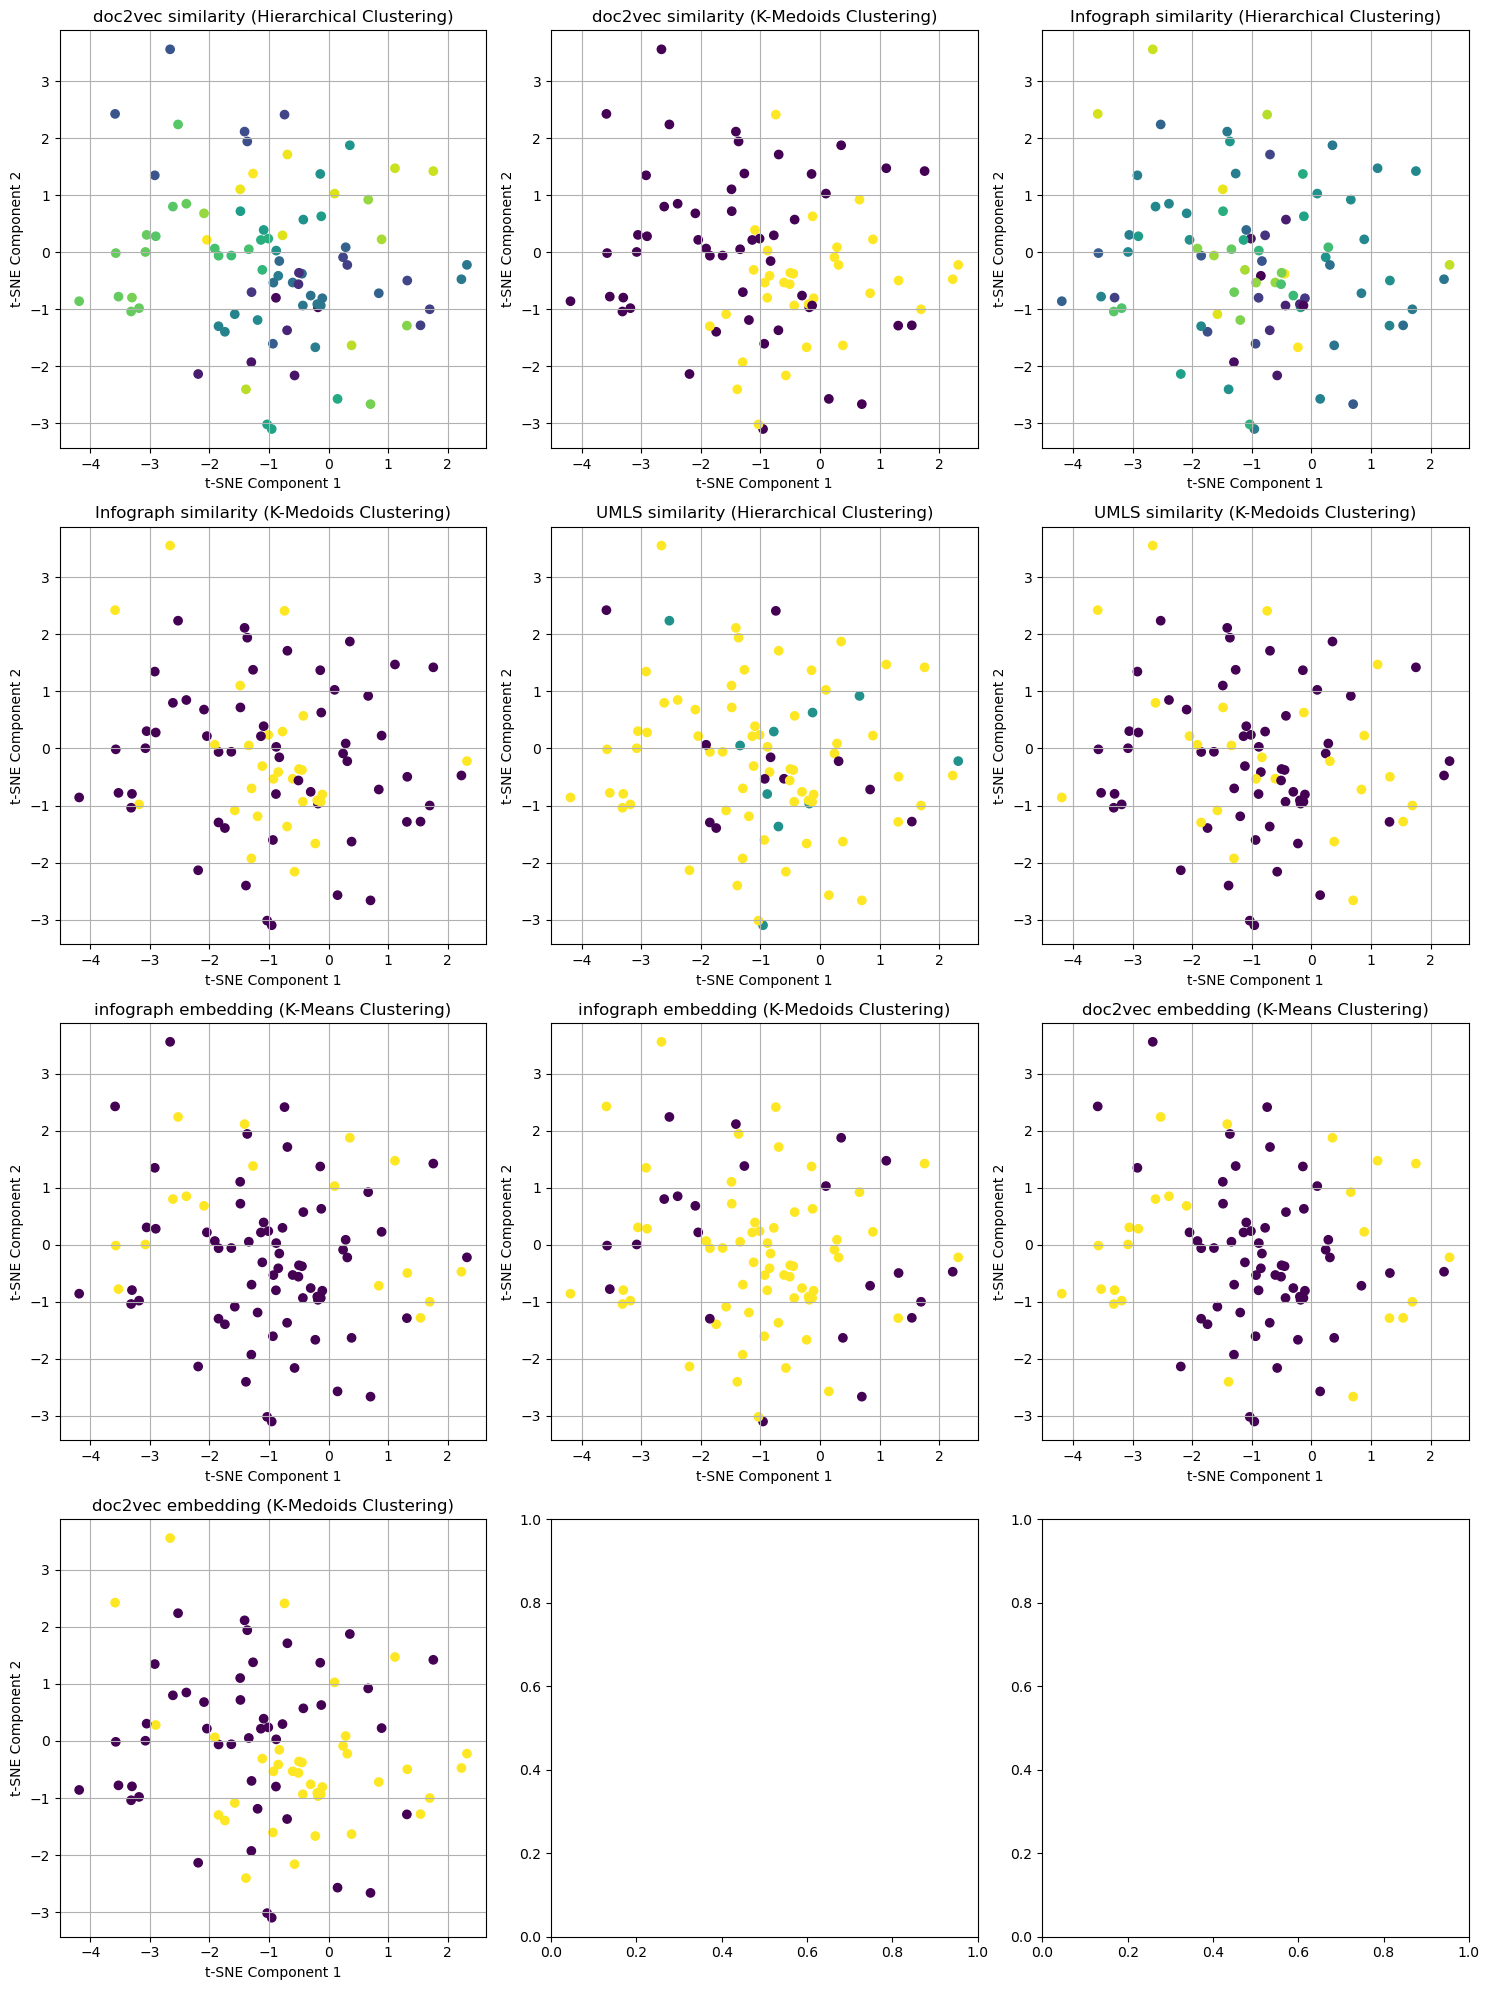

In [41]:
import matplotlib.pyplot as plt

# Impostazione delle dimensioni della figura e della griglia dei subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Lista dei dati e delle etichette dei titoli per ogni grafico
data = [
    (clustersHierarchicaldoc2vec[:84], 'doc2vec similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSdoc2vec[:84], 'doc2vec similarity (K-Medoids Clustering)'),
    (clustersHierarchicalInfoGraph[:84], 'Infograph similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSInfoGraph[:84], 'Infograph similarity (K-Medoids Clustering)'),
    (clustersHierarchicalUMLS[:84], 'UMLS similarity (Hierarchical Clustering)'),
    (clustersKMEDOIDSUMLS[:84], 'UMLS similarity (K-Medoids Clustering)'),
    (clustersKMEANSInfoGraphEMB[:84], 'infograph embedding (K-Means Clustering)'),
    (clustersKMEDOIDSInfoGraphEMB[:84], 'infograph embedding (K-Medoids Clustering)'),
    (clustersKMEANSdoc2vecEMB[:84], 'doc2vec embedding (K-Means Clustering)'),
    (clustersKMEDOIDSdoc2vecEMB[:84], 'doc2vec embedding (K-Medoids Clustering)')
]

# Creazione dei grafici per ogni coppia di dati e titoli
for i, (cluster_data, title) in enumerate(data):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_data, cmap='viridis')
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('t-SNE Component 1')
    axes[row, col].set_ylabel('t-SNE Component 2')
    axes[row, col].grid(True)

# Regolazione dello spaziatura tra i subplots
plt.tight_layout()

# Visualizzazione della griglia di subplots
plt.show()

 faccio per tutti i metodi anche KMEDOID al posto di kmeans quando do in input la matrice di similarità perchè questo dovrebbe essere meglio (kmeans non funziona con matrice di similarità! https://stats.stackexchange.com/questions/32925/perform-k-means-or-its-close-kin-clustering-with-only-a-distance-matrix-not-p)

Tutti i clusters assieme:


# NB osservo che se uso doc2vec come confronto posso utilizzare anche il layer 3!!: clustering kmeans su layer 3:

In [42]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs3)  # embeddings è la tua matrice di embedding

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [43]:
len(embeddings_tsne[:, 0])

2129

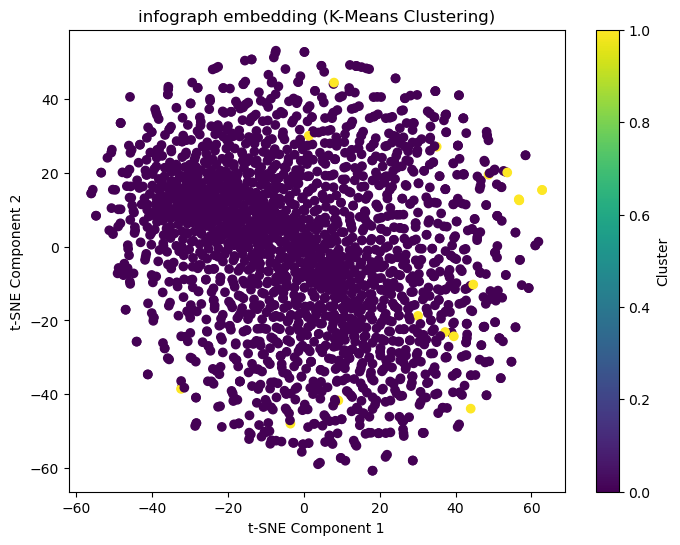

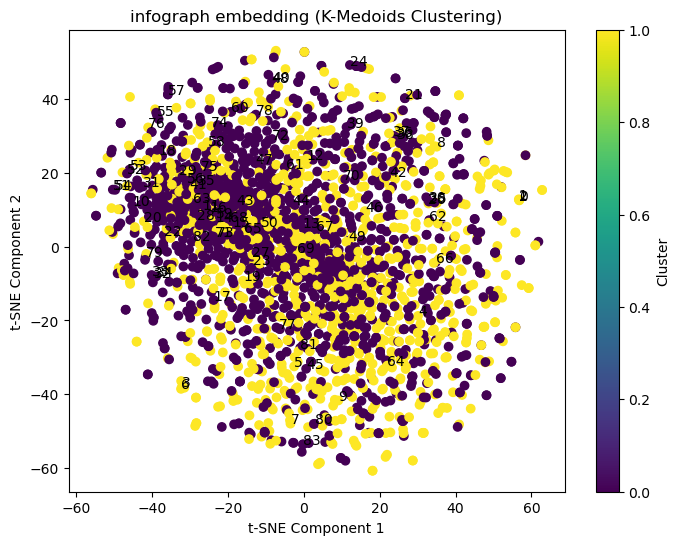

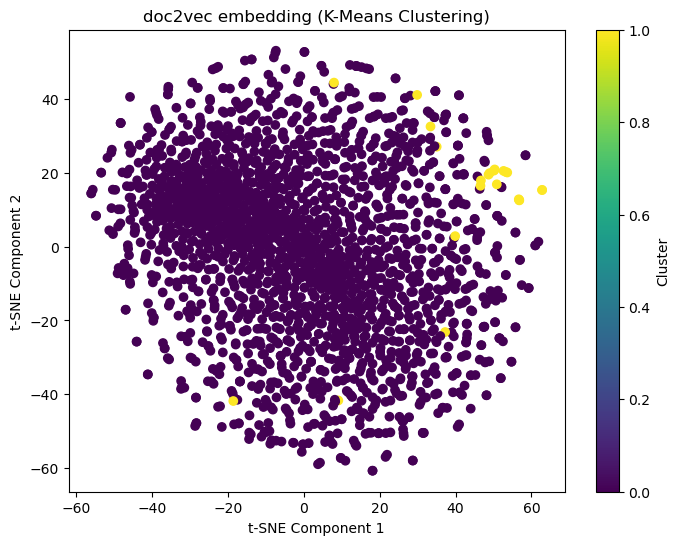

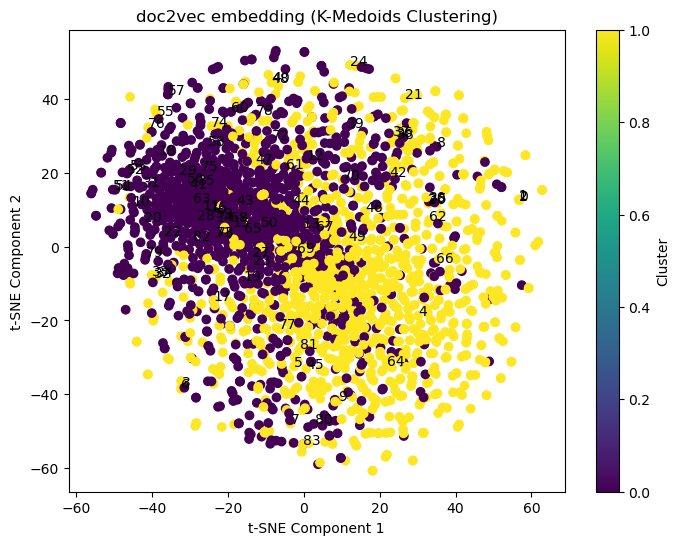

In [44]:
# infograph embedding:
#kmeans


kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb3)
clustersKMEANSInfoGraphEMB3 = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSInfoGraphEMB3, cmap='viridis')
plt.title('infograph embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.show()


#kmedoids
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(emb3)
clustersKMEDOIDSInfoGraphEMB3 = kmedoids.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSInfoGraphEMB3, cmap='viridis')
plt.title('infograph embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()


# doc2vec embedding:
#kmeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(embedding_docs3)
clustersKMEANSdoc2vecEMB3 = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEANSdoc2vecEMB3, cmap='viridis')
plt.title('doc2vec embedding (K-Means Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.show()


#kmedoids

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(embedding_docs3)
clustersKMEDOIDSdoc2vecEMB3 = kmedoids.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clustersKMEDOIDSdoc2vecEMB3, cmap='viridis')
plt.title('doc2vec embedding (K-Medoids Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))
plt.show()



In [45]:
print(clustersKMEANSdoc2vecEMB3)
count_1 = np.count_nonzero(clustersKMEANSdoc2vecEMB3 == 1)

# Conta quanti 0 ci sono nell'array
count_0 = np.count_nonzero(clustersKMEANSdoc2vecEMB3 == 0)

print("Numero di 1 nella lista:", count_1)
print("Numero di 0 nella lista:", count_0)

count_1 = np.count_nonzero(clustersKMEANSInfoGraphEMB3 == 1)

# Conta quanti 0 ci sono nell'array
count_0 = np.count_nonzero(clustersKMEANSInfoGraphEMB3 == 0)

print("Numero di 1 nella lista:", count_1)
print("Numero di 0 nella lista:", count_0)

[1 1 1 ... 1 1 1]
Numero di 1 nella lista: 23
Numero di 0 nella lista: 2106
Numero di 1 nella lista: 18
Numero di 0 nella lista: 2111


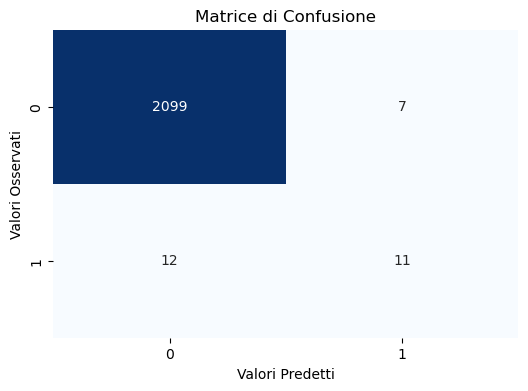

In [46]:
from sklearn.metrics import confusion_matrix

# Esempio di array di valori osservati e array di valori predetti
valori_osservati = clustersKMEANSdoc2vecEMB3
valori_predetti = clustersKMEANSInfoGraphEMB3

# Creazione della matrice di confusione
matrice_confusione = confusion_matrix(valori_osservati, valori_predetti)

import seaborn as sns
# Creazione del plot della matrice di confusione
plt.figure(figsize=(6, 4))
sns.heatmap(matrice_confusione, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valori Predetti')
plt.ylabel('Valori Osservati')
plt.title('Matrice di Confusione')
plt.show()


***
***
# Confronto fra clusters (mapping dei clusters)
***
***

Vediamo quanta corrispondenza c'è fra vari metodi in maniera molto semplice:

# Modfiche nuove (28 Febbraio)
La mia idea è quella di visualizzare gli embedding di layer 1 colorati in base alla fonte diversa (source) e vedere se si formano dei clusters o qualcosa del genere.

Una cosa simile che si potrebbe fare è visualizzare gli embedding mettendo una label per ogni documento sulla base di tipologia di paziente in analisi (cancro, cardiologia, gastro intestinali...). Questo si potrebbe fare seguendo l'idea del Vittorio di usare le clinical entities per classificare il paziente in una di queste categorie (majority voting delle clinical entities di un tipo determina l'assegnazione a quella categoria dell'intero documento.

Nella parte di codice dove creo il file lista_testi ho aggiunto anche la creazione lista_source, in tal maniera ho una lista di 84 per layer 1 contenente le informazioni con la provenienza di ogni documento.

Plotto embeddings layer 1 sulla base della provenienza:

***
***
Plot embeddings sulla base della provenienza dell'articolo
***
***

In [47]:
lista_source_unique1 = list(set(lista_source1)) # 13 source diverse
lista_source_coloration1 = [lista_source_unique1.index(word) for word in lista_source1]
# così facendo associo un numero unico a ogni "source" dei documenti (un po'tricky ma dovrebbe funzionare), poi passo questi 
# numeri a "c" per colorare in tal maniera i documenti

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


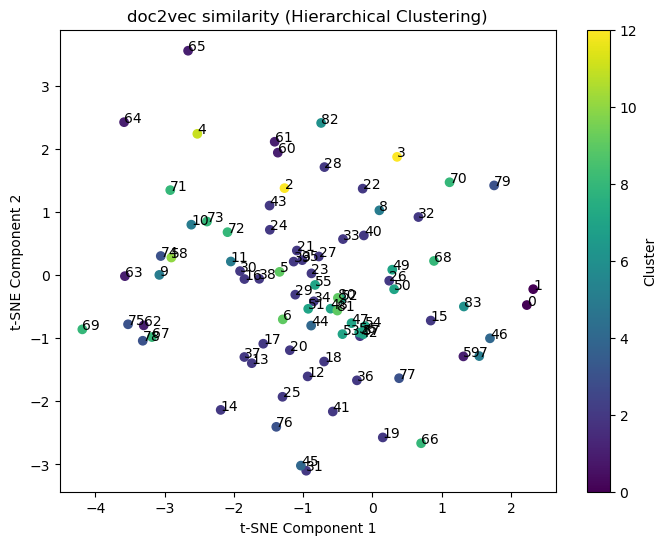

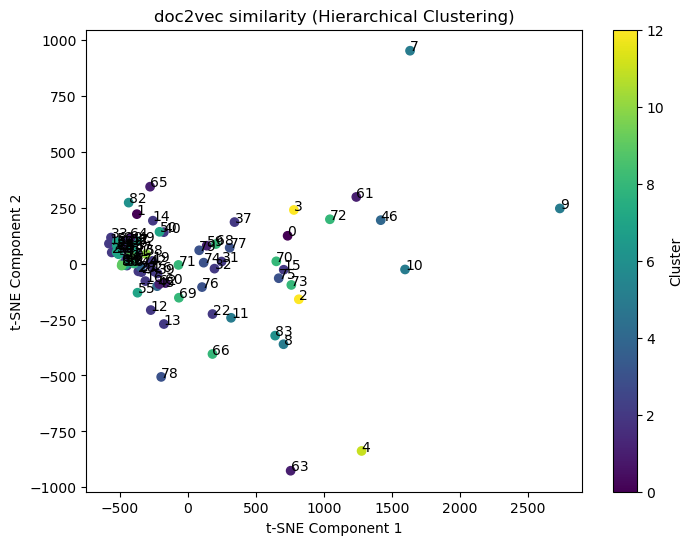

In [48]:
# doc2vec:

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs1)  # embeddings è la tua matrice di embedding

# Calcola PCA sui tuoi embedding
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pcaInfoGraph = pca.fit_transform(emb1) 


plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=lista_source_coloration1, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1], c=lista_source_coloration1, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1]))

plt.show()

Così è forse un po'confuso, rimuovo le etichette dei gruppi con meno di 3 punti, li assegno al cluster generico "other", altrimenti ho 13 gruppi e si capisce poco!

In [49]:
occorrenze = {}

for parola in lista_source1:
    occorrenze[parola] = occorrenze.get(parola,0)+1
    
lista_source_more_than_four1 = list(lista_source1)
for i,parola in enumerate(lista_source1):
    if occorrenze[parola] <= 7:
        lista_source_more_than_four1[i] ='other'
lista_source_more_than_four_unique1 = list(set(lista_source_more_than_four1)) # 13 source diverse
lista_source_more_than_four_coloration1 = [lista_source_more_than_four_unique1.index(word) for word in lista_source_more_than_four1]
# così facendo associo un numero unico a ogni "source" dei documenti (un po'tricky ma dovreb

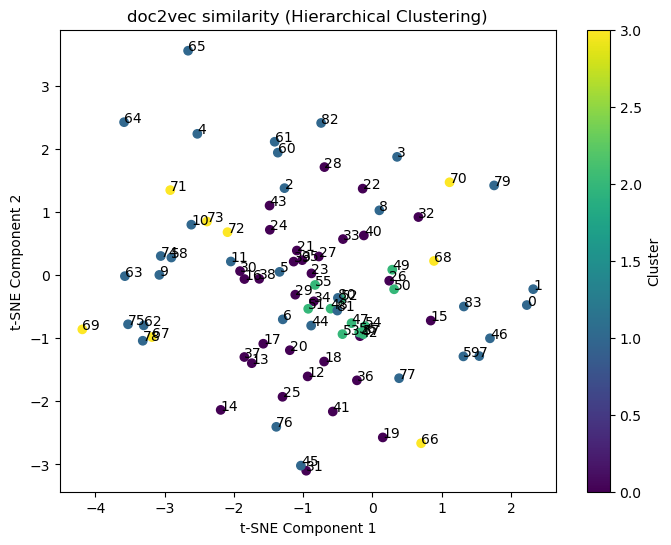

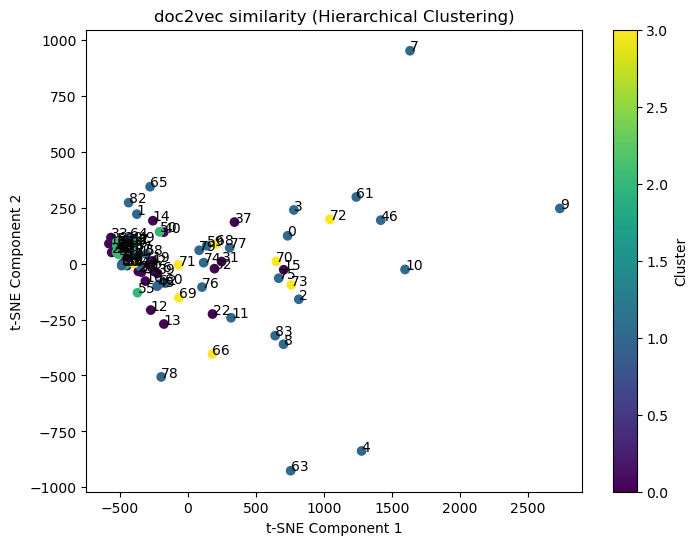

In [50]:



plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=lista_source_more_than_four_coloration1, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1], c=lista_source_more_than_four_coloration1, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1]))

plt.show()

Provo a migliorare questo plot (mezzo fallimento la legenda non si colora)

In [51]:
lista_source_more_than_four_unique1

['Italian Journal of Medicine',
 'other',
 'Sapienza Università di Roma',
 'Pediatric Reports']

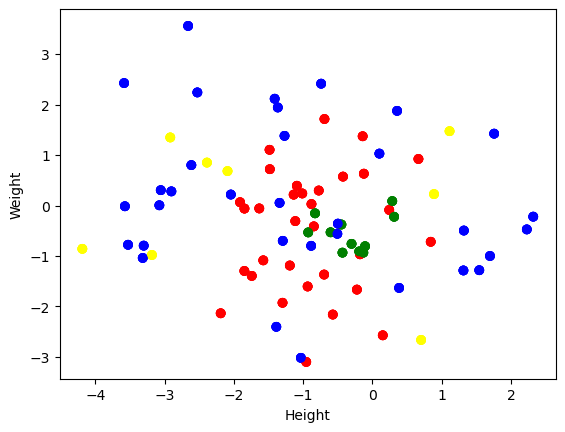

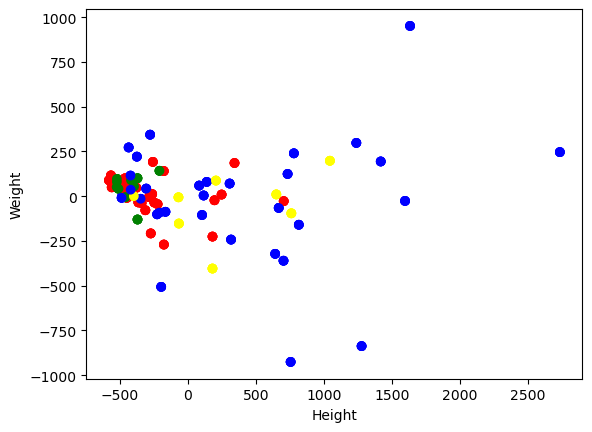

In [52]:
lista_source_more_than_four_unique1 = list(set(lista_source_more_than_four1)) #lunghezza 7
lista_source_more_than_four_coloration1 = [lista_source_more_than_four_unique1.index(word) for word in lista_source_more_than_four1]
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange','black']

#  'Sapienza Università di Roma', ROSSO
# 'Clinical Management Issues', BLU
# 'La Pediatria Medica e Chirurgica', VERDE
# 'Pediatric Reports', GIALLO
# 'other', VIOLA
# 'pediatric reports', ARANCIONE
# 'Italian Journal of Medicine' NERO

#  'Sapienza Università di Roma', ROSSO
# ''Italian Journal of Medicine'', BLU
# 'other, VERDE
# 'Pediatric Reports', GIALLO


lista_source_more_than_four_colorationSTRING1 = [colors[num] for num in lista_source_more_than_four_coloration1]

for i in range(len(lista_source_more_than_four_unique1)):
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], color=lista_source_more_than_four_colorationSTRING1, label=lista_source_more_than_four_unique1[i])

# Add labels and legend
plt.xlabel('Height')
plt.ylabel('Weight')
#plt.legend()

# Show the plot
plt.show()

#  'Sapienza Università di Roma', ROSSO
# 'Clinical Management Issues', BLU
# 'La Pediatria Medica e Chirurgica', VERDE
# 'Pediatric Reports', GIALLO
# 'other', VIOLA
# 'pediatric reports', ARANCIONE
# 'Italian Journal of Medicine' NERO

for i in range(len(lista_source_more_than_four_unique1)):
    plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1], color=lista_source_more_than_four_colorationSTRING1, label=lista_source_more_than_four_unique1[i])

# Add labels and legend
plt.xlabel('Height')
plt.ylabel('Weight')
#plt.legend()

# Show the plot
plt.show()

#  'Sapienza Università di Roma', ROSSO
# 'Clinical Management Issues', BLU
# 'La Pediatria Medica e Chirurgica', VERDE
# 'Pediatric Reports', GIALLO
# 'other', VIOLA
# 'pediatric reports', ARANCIONE
# 'Italian Journal of Medicine' NERO

#  'Sapienza Università di Roma', ROSSO
# ''Italian Journal of Medicine'', BLU
# 'other, VERDE
# 'Pediatric Reports', GIALLO


Osservo che ci sono sia documenti da pediactric reports che da Pediatric Reports, cambiando la lettera maiuscola,
si potrebbe pensaredi unirli

Ho runnato di nuovo il codice per la creazione di lista_source_more_than_four e settando la threshold più alta viene qualcosa di piu carino ad esempio se mettessi solo sapienza e journal of medicine e resto other (ovvero mettendo gialli assieme ai verdi), verrebbe qualcosa di perfetto!

OSS: osservo che infograph e doc2vec producono risultati simili

In [53]:
lista_source_unique1 = list(set(lista_source1)) # 13 source diverse
lista_source_coloration1 = [lista_source_unique1.index(word) for word in lista_source1]
# così facendo associo un numero unico a ogni "source" dei documenti (un po'tricky ma dovrebbe funzionare), poi passo questi 
# numeri a "c" per colorare in tal maniera i documenti

In [54]:
occorrenze = {}

for parola in lista_source1:
    occorrenze[parola] = occorrenze.get(parola,0)+1
print(occorrenze)

{'AboutOpen': 2, 'GCND Giornale di Clinica Nefrologica e Dialisi': 2, 'Argomenti di Oncologia Geriatrica': 1, 'Miur': 4, 'Clinical Management Issues': 5, 'Italian Journal of Medicine': 32, 'Italian Journal of Emergency Medicine': 3, 'Sapienza Università di Roma': 11, 'microbiologia medica': 1, 'La Pediatria Medica e Chirurgica': 7, 'Pediatric Reports': 8, 'pediatric reports': 6, 'Prof. Dr. Francescopaolo Mattioli': 2}


In [55]:
somma = {}

for i,parola in enumerate(lista_source1):
    somma[parola] = somma.get(parola,0)+len((lista_testi1[i]))
    
print(somma,"\n")

occorrenze = {}

for parola in lista_source1:
    occorrenze[parola] = occorrenze.get(parola,0)+1
print(occorrenze,"\n")

media = {}
for parola in somma:
    media[parola] = somma[parola]/occorrenze[parola]
print(media)
    

{'AboutOpen': 6534, 'GCND Giornale di Clinica Nefrologica e Dialisi': 6232, 'Argomenti di Oncologia Geriatrica': 3829, 'Miur': 2494, 'Clinical Management Issues': 18366, 'Italian Journal of Medicine': 46663, 'Italian Journal of Emergency Medicine': 8770, 'Sapienza Università di Roma': 7348, 'microbiologia medica': 1716, 'La Pediatria Medica e Chirurgica': 17268, 'Pediatric Reports': 21735, 'pediatric reports': 18767, 'Prof. Dr. Francescopaolo Mattioli': 6219} 

{'AboutOpen': 2, 'GCND Giornale di Clinica Nefrologica e Dialisi': 2, 'Argomenti di Oncologia Geriatrica': 1, 'Miur': 4, 'Clinical Management Issues': 5, 'Italian Journal of Medicine': 32, 'Italian Journal of Emergency Medicine': 3, 'Sapienza Università di Roma': 11, 'microbiologia medica': 1, 'La Pediatria Medica e Chirurgica': 7, 'Pediatric Reports': 8, 'pediatric reports': 6, 'Prof. Dr. Francescopaolo Mattioli': 2} 

{'AboutOpen': 3267.0, 'GCND Giornale di Clinica Nefrologica e Dialisi': 3116.0, 'Argomenti di Oncologia Geriat

***
***
Classificazione provenienza da layer 3 a layer 1
***
***

L'idea è che prendo gli embeddings di infograph di layer 3, traino un classificatore classico e poi vedo come performa su layer 1 (test set).

Valuto anche gli embedding di layer 3 colorati per source!

In [56]:
import json

# Definisci la cartella contenente i file
cartella = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_collection\Italian\layer3"

# Lista dei testi estratti
lista_source3 = []

# Itera su tutti i file nella cartella
for filename in tqdm(os.listdir(cartella)):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                if "source" in data:
                    source = data["source"]
                    if source !='Agenzia Italiana del Farmaco':
                        lista_source3.append(source)
            except Exception as e:
                pass

  0%|          | 0/10213 [00:00<?, ?it/s]

In [57]:
len(lista_source3)

2129

In [58]:
lista_testi3 = []

# Itera su tutti i file nella cartella
for filename in tqdm(os.listdir(cartella)):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                if "source" in data:
                    source = data["source"]
                if "text" in data and "source" :
                    testo = data["text"]
                    
                    if source !='Agenzia Italiana del Farmaco':
                        lista_testi3.append(testo)
            except Exception as e:
                pass

  0%|          | 0/10213 [00:00<?, ?it/s]

In [59]:
lista_source_unique3 = list(set(lista_source3)) # 13 source diverse
print(lista_source_unique3)
lista_source_coloration3 = [lista_source_unique3.index(word) for word in lista_source3]
# così facendo associo un numero unico a ogni "source" dei documenti (un po'tricky ma dovrebbe funzionare), poi passo questi 
# numeri a "c" per colorare in tal maniera i documenti

occorrenze = {}

for parola in lista_source3:
    occorrenze[parola] = occorrenze.get(parola,0)+1
print(occorrenze)
lista_source_more_than_four3 = list(lista_source3)
#for i,parola in enumerate(lista_source):
 #   if occorrenze[parola] <= 7:
  #      lista_source_more_than_four[i] ='other'

['La Pediatria Medica e Chirurgica', 'Italian Journal of Medicine', 'GCND Giornale di Clinica Nefrologica e Dialisi', 'Italian Journal of Emergency Medicine', 'Clinical Management Issues', 'pediatric reports', 'Prof. Dr. Francescopaolo Mattioli', 'Sapienza Università di Roma', 'Pediatric Reports', 'Miur', 'microbiologia medica', 'Hematology Reports']
{'GCND Giornale di Clinica Nefrologica e Dialisi': 10, 'Miur': 1439, 'Clinical Management Issues': 1, 'Hematology Reports': 6, 'Italian Journal of Medicine': 534, 'Italian Journal of Emergency Medicine': 4, 'Sapienza Università di Roma': 89, 'microbiologia medica': 17, 'La Pediatria Medica e Chirurgica': 6, 'Pediatric Reports': 8, 'pediatric reports': 6, 'Prof. Dr. Francescopaolo Mattioli': 9}


un'idea potrebbe essere quella di prendere solo i documenti da Sapienza Università di Roma Italian Journal of Medicine e magari Miur perchè hanno un campione abbasatanza ampio sia in layer 3 che layer 1. Ad esempio 'Agenzia Italiana del Farmaco': 8084 ha quasi tutti i documenti questo potrebbe sporcare i nostri risultati.

Una cosa interessante venuta fuori è che 'Agenzia Italiana del Farmaco': 8084 ha quasi tutti i documenti del corpus quindi forse potrebbe essere sensato rimuoverli prima di procedere col training di infograph in generale!!

Faccio plotting dei punti come avevo fatto con layer1 ma con layer 3

In [60]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsneInfoGraph = tsne.fit_transform(emb3)  # embeddings è la tua matrice di embedding

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


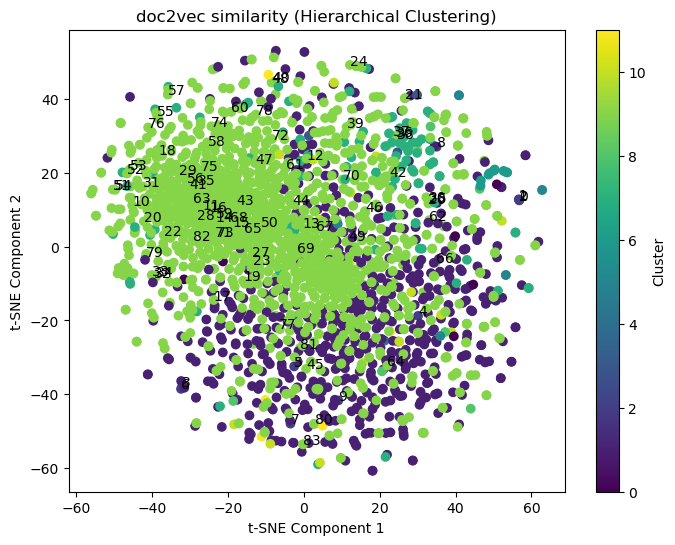

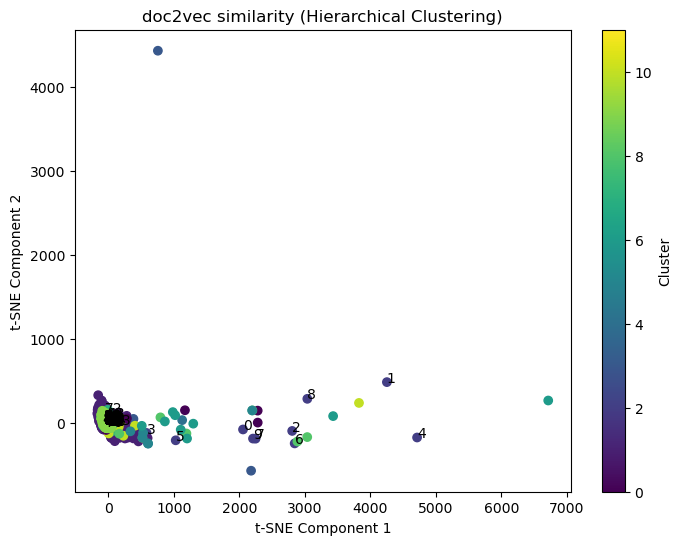

In [61]:
# doc2vec:

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_docs3)  # embeddings è la tua matrice di embedding

# Calcola PCA sui tuoi embedding
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pcaInfoGraph = pca.fit_transform(emb3) 

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsneInfoGraph = tsne.fit_transform(emb3)  # embeddings è la tua matrice di embedding


plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=lista_source_coloration3, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1], c=lista_source_coloration3, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1]))

plt.show()

In [62]:
occorrenze = {}

for parola in lista_source3:
    occorrenze[parola] = occorrenze.get(parola,0)+1
    
lista_source_more_than_four3 = list(lista_source3)
for i,parola in enumerate(lista_source3):
    if occorrenze[parola] <= 50:
        lista_source_more_than_four3[i] ='other'
lista_source_more_than_four_unique3 = list(set(lista_source_more_than_four3)) # 13 source diverse
lista_source_more_than_four_coloration3 = [lista_source_more_than_four_unique3.index(word) for word in lista_source_more_than_four3]
# così facendo associo un numero unico a ogni "source" dei documenti (un po'tricky ma dovreb

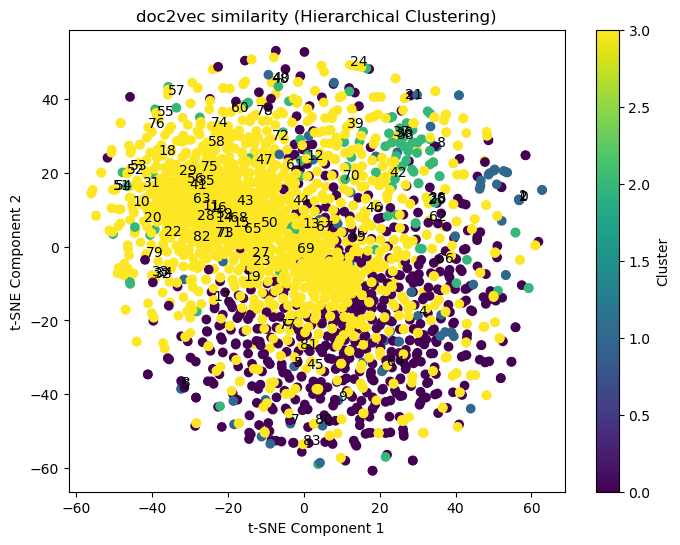

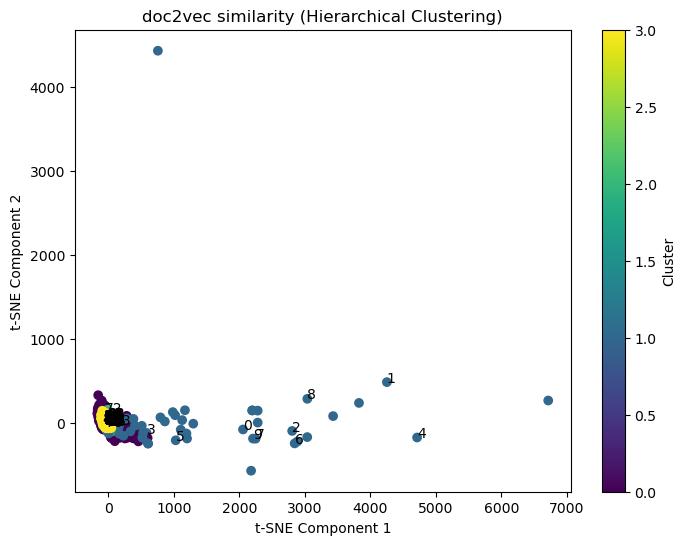

In [63]:


plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=lista_source_more_than_four_coloration3, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1], c=lista_source_more_than_four_coloration3, cmap='viridis')
plt.title('doc2vec similarity (Hierarchical Clustering)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
# Annota i punti con gli indici
for i, txt in enumerate(range(84)):
    plt.annotate(txt, (embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1]))

plt.show()

In [73]:
lista_source_more_than_four_unique3

['Italian Journal of Medicine', 'other', 'Sapienza Università di Roma', 'Miur']

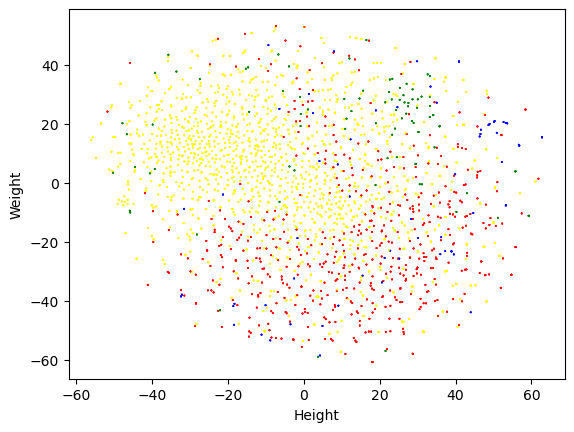

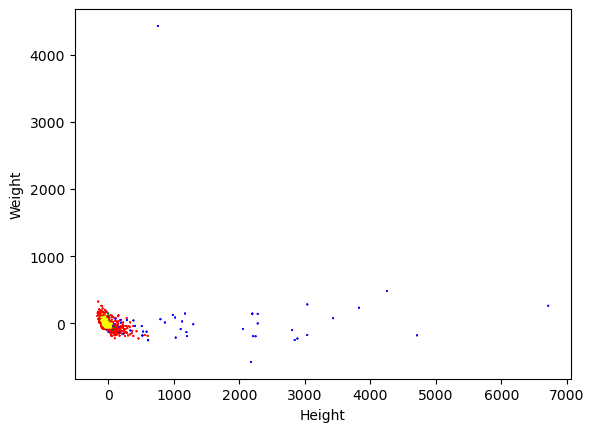

  0%|          | 0/4 [00:00<?, ?it/s]

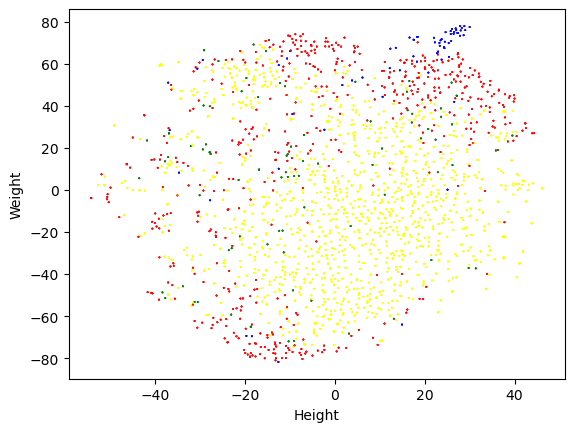

In [65]:
lista_source_more_than_four_unique3 = list(set(lista_source_more_than_four3)) #lunghezza 7
lista_source_more_than_four_coloration3 = [lista_source_more_than_four_unique3.index(word) for word in lista_source_more_than_four3]
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange','black']

#  'Miur', ROSSO
# 'other', BLU
# 'Sapienza Università di Roma', VERDE
# 'Italian Journal of Medicine', GIALLO
# 'Agenzia Italiana del Farmaco', VIOLA

lista_source_more_than_four_unique3

lista_source_more_than_four_colorationSTRING3 = [colors[num] for num in lista_source_more_than_four_coloration3]

for i in range(len(lista_source_more_than_four_unique3)):
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s = 0.1, color=lista_source_more_than_four_colorationSTRING3, label=lista_source_more_than_four_unique3[i])

# Add labels and legend
plt.xlabel('Height')
plt.ylabel('Weight')
#plt.legend()

# Show the plot
plt.show()

#  'Miur', ROSSO
# 'other', BLU
# 'Sapienza Università di Roma', VERDE
# 'Italian Journal of Medicine', GIALLO
# 'Agenzia Italiana del Farmaco', VIOLA

for i in range(len(lista_source_more_than_four_unique3)):
    plt.scatter(embeddings_pcaInfoGraph[:, 0], embeddings_pcaInfoGraph[:, 1],s = 0.1, color=lista_source_more_than_four_colorationSTRING3, label=lista_source_more_than_four_unique3[i])

# Add labels and legend
plt.xlabel('Height')
plt.ylabel('Weight')
#plt.legend()

# Show the plot
plt.show()

for i in tqdm(range(len(lista_source_more_than_four_unique3))):
    plt.scatter(embeddings_tsneInfoGraph[:, 0], embeddings_tsneInfoGraph[:, 1],s = 0.1, color=lista_source_more_than_four_colorationSTRING3, label=lista_source_more_than_four_unique3[i])

# Add labels and legend
plt.xlabel('Height')
plt.ylabel('Weight')
#plt.legend()

# Show the plot
plt.show()


#  'Miur', ROSSO
# 'other', BLU
# 'Sapienza Università di Roma', VERDE
# 'Italian Journal of Medicine', GIALLO
# 'Agenzia Italiana del Farmaco', VIOLA

Come si può notare benissimo qua, sia nel caso di infograph che di doc2vec si formano dei cluster ben definiti sulla base della provenienza del documento!

Come per layer 1 faccio analisi sulla lunghezza dei documenti:

In [66]:
somma = {}

for i,parola in enumerate(lista_source3):
    somma[parola] = somma.get(parola,0)+len((lista_testi3[i]))
    
print(somma,"\n")

occorrenze = {}

for parola in lista_source3:
    occorrenze[parola] = occorrenze.get(parola,0)+1
print(occorrenze,"\n")

media = {}
for parola in somma:
    media[parola] = somma[parola]/occorrenze[parola]
print(media)

{'GCND Giornale di Clinica Nefrologica e Dialisi': 46984, 'Miur': 331537, 'Clinical Management Issues': 4463, 'Hematology Reports': 6863, 'Italian Journal of Medicine': 625297, 'Italian Journal of Emergency Medicine': 11041, 'Sapienza Università di Roma': 53274, 'microbiologia medica': 23897, 'La Pediatria Medica e Chirurgica': 18627, 'Pediatric Reports': 27723, 'pediatric reports': 18706, 'Prof. Dr. Francescopaolo Mattioli': 54496} 

{'GCND Giornale di Clinica Nefrologica e Dialisi': 10, 'Miur': 1439, 'Clinical Management Issues': 1, 'Hematology Reports': 6, 'Italian Journal of Medicine': 534, 'Italian Journal of Emergency Medicine': 4, 'Sapienza Università di Roma': 89, 'microbiologia medica': 17, 'La Pediatria Medica e Chirurgica': 6, 'Pediatric Reports': 8, 'pediatric reports': 6, 'Prof. Dr. Francescopaolo Mattioli': 9} 

{'GCND Giornale di Clinica Nefrologica e Dialisi': 4698.4, 'Miur': 230.39402362751912, 'Clinical Management Issues': 4463.0, 'Hematology Reports': 1143.8333333333

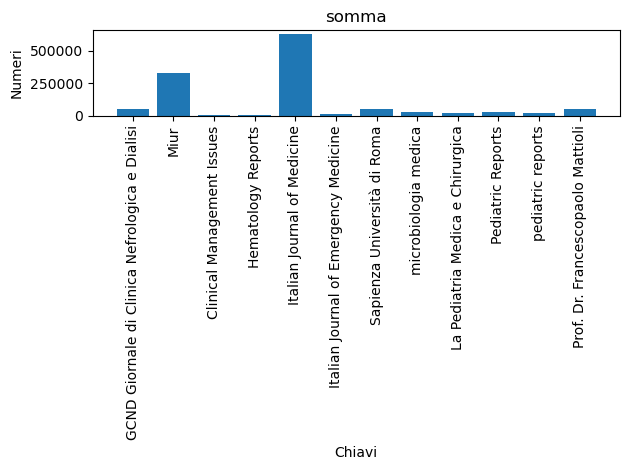

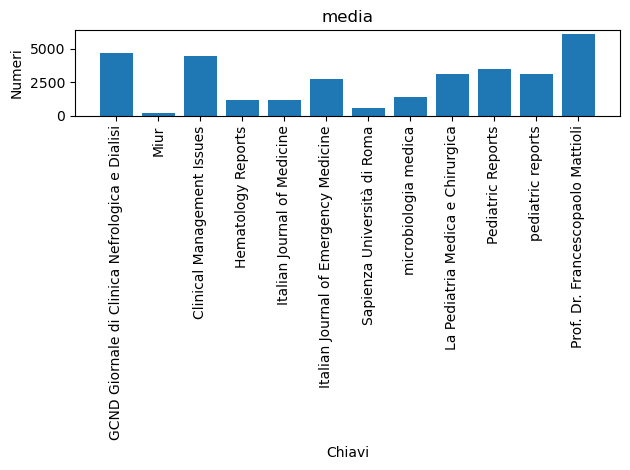

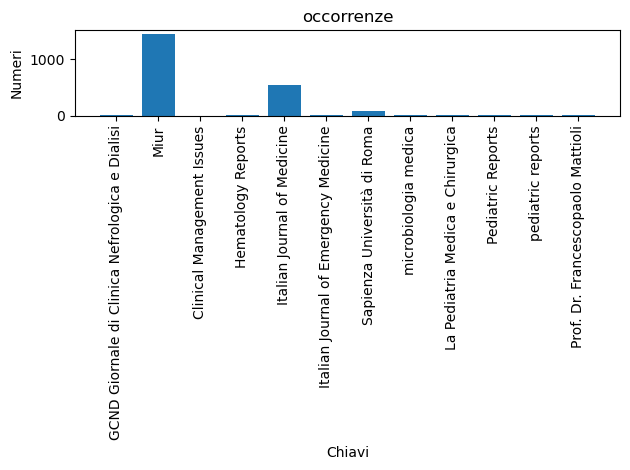

In [67]:
chiavi = list(somma.keys())
valori = list(somma.values())

plt.bar(chiavi, valori)

# Aggiungi titoli e label
plt.title('somma')
plt.xlabel('Chiavi')
plt.ylabel('Numeri')

# Mostra il grafico
plt.xticks(rotation=90)

# Mostra il grafico
plt.tight_layout()

plt.show()

chiavi = list(media.keys())
valori = list(media.values())

plt.bar(chiavi, valori)

# Aggiungi titoli e label
plt.title('media')
plt.xlabel('Chiavi')
plt.ylabel('Numeri')
plt.xticks(rotation=90)

# Mostra il grafico
plt.tight_layout()
# Mostra il grafico
plt.show()


chiavi = list(occorrenze.keys())
valori = list(occorrenze.values())

plt.bar(chiavi, valori)

# Aggiungi titoli e label
plt.title('occorrenze')
plt.xlabel('Chiavi')
plt.ylabel('Numeri')
plt.xticks(rotation=90)

# Mostra il grafico
plt.tight_layout()
# Mostra il grafico
plt.show()

Plotto ora documenti sulla base della loro lunghezza. Classifico la lunghezza dei documenti come:
    Lunghi: > 5000 parole
        Corti: < 1000 parole
            Medi: 1000<parole<5000

versione ottimizzata:

0it [00:00, ?it/s]

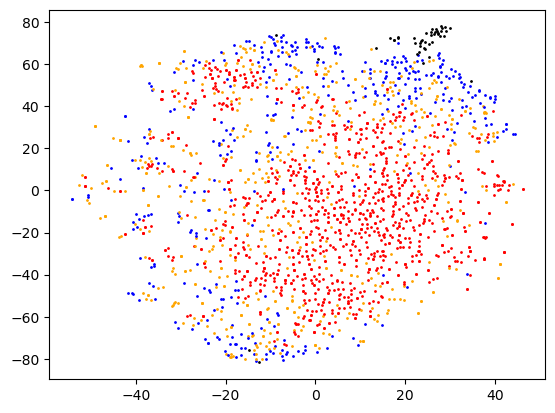

In [68]:
lunghezze_testi = [len(testo) for testo in lista_testi3]

for i, lunghezza in tqdm(enumerate(lunghezze_testi)):
    if len(lista_testi3[i])<300:
        col = 'red'
        label = 'CORTO'
    elif len(lista_testi3[i]) > 2000:
        col = 'black'
        label = 'MOLTO LUNGO'
    elif len(lista_testi3[i]) > 1000 and len(lista_testi3[i]) < 2000:
        col = 'blue'
        label = 'LUNGO'
    else:
        col = 'orange'
        label = 'MEDIO'
        
    plt.scatter(embeddings_tsneInfoGraph[i, 0], embeddings_tsneInfoGraph[i, 1], s=1, color=col, label=label)

# Aggiungi la legenda per le etichette
# plt.legend() con la legendea non mi fa visualizzare l'immagine!

# Mostra il plot
plt.savefig('immagini\InfoGraphTSNELayer3LunghezzaTesti'+stringa_AIFA+'.svg')
plt.show()

0it [00:00, ?it/s]

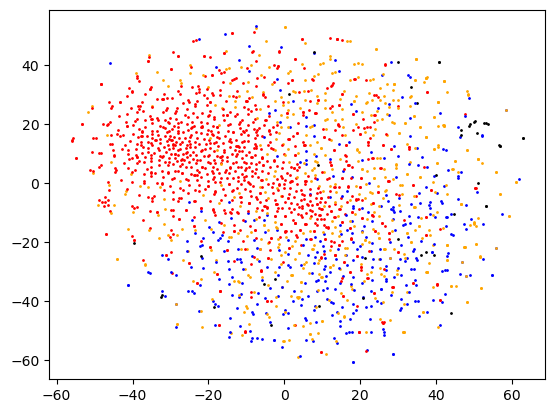

In [69]:
lunghezze_testi = [len(testo) for testo in lista_testi3]

for i, lunghezza in tqdm(enumerate(lunghezze_testi)):
    if len(lista_testi3[i])<300:
        col = 'red'
        label = 'CORTO'
    elif len(lista_testi3[i]) > 2000:
        col = 'black'
        label = 'MOLTO LUNGO'
    elif len(lista_testi3[i]) > 1000 and len(lista_testi3[i]) < 2000:
        col = 'blue'
        label = 'LUNGO'
    else:
        col = 'orange'
        label = 'MEDIO'
    plt.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], s=1, color=col, label=label)

# Aggiungi la legenda per le etichette

# Mostra il plot
plt.savefig('immagini\Doc2vecTSNELayer3LunghezzaTesti'+stringa_AIFA+'.svg')
plt.show()

0it [00:00, ?it/s]

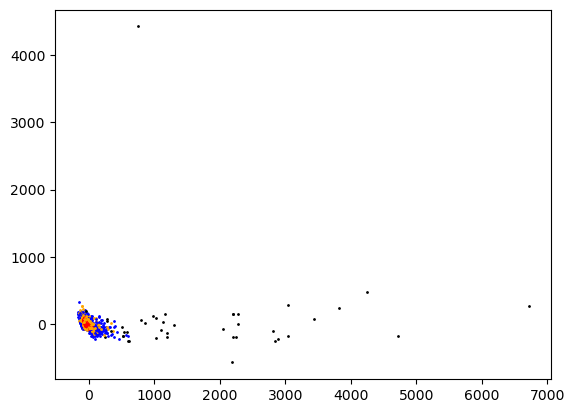

In [70]:
lunghezze_testi = [len(testo) for testo in lista_testi3]

for i, lunghezza in tqdm(enumerate(lunghezze_testi)):
    if len(lista_testi3[i])<300:
        col = 'red'
        label = 'CORTO'
    elif len(lista_testi3[i]) > 2000:
        col = 'black'
        label = 'MOLTO LUNGO'
    elif len(lista_testi3[i]) > 1000 and len(lista_testi3[i]) < 2000:
        col = 'blue'
        label = 'LUNGO'
    else:
        col = 'orange'
        label = 'MEDIO'
        
    plt.scatter(embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1], s=1, color=col, label=label)


# Mostra il plot
plt.savefig('immagini\plot'+stringa_AIFA+'.svg')
plt.show()


Qua a causa degli outlier è tutto schiacciato e non si vede niente, sistemo settando xlim e ylim:

0it [00:00, ?it/s]

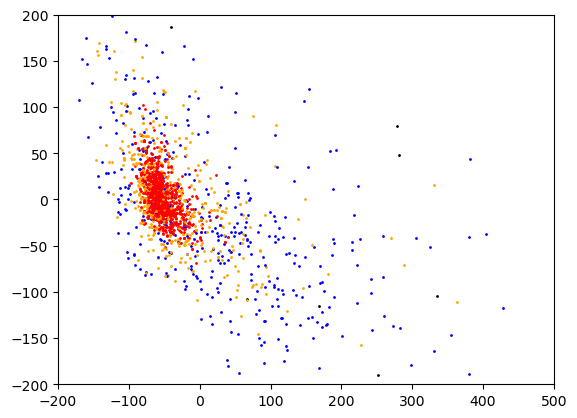

In [72]:
lunghezze_testi = [len(testo) for testo in lista_testi3]

for i, lunghezza in tqdm(enumerate(lunghezze_testi)):
    if len(lista_testi3[i])<300:
        col = 'red'
        label = 'CORTO'
    elif len(lista_testi3[i]) > 2000:
        col = 'black'
        label = 'MOLTO LUNGO'
    elif len(lista_testi3[i]) > 1000 and len(lista_testi3[i]) < 2000:
        col = 'blue'
        label = 'LUNGO'
    else:
        col = 'orange'
        label = 'MEDIO'
        
    plt.scatter(embeddings_pcaInfoGraph[i, 0], embeddings_pcaInfoGraph[i, 1], s=1, color=col, label=label)


# Mostra il plot
plt.xlim(-200, 500)
plt.ylim(-200, 200)
plt.savefig('immagini\plot'+stringa_AIFA+'.svg')
plt.show()
